In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys, os, re, glob, parse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')
sns.set_style('white')
sns.set_palette('muted')

ligan_root = 'C:\\Users\mtr22\Code\liGAN'
sys.path.append(ligan_root)
import results

print('SSHFS status\n------------')
print('Bridges {}'.format(os.path.exists('E:\\')))
print('CSB     {}'.format(os.path.exists('D:\\')))
print('CRC     {}'.format(os.path.exists('F:\\')))

SSHFS status
------------
Bridges True
CSB     False
CRC     False


# train.py

In [2]:
def read_err_file(err_file):
    error = None
    with open(err_file, encoding='utf-8') as f:
        for line in f:
            if not re.match('Warning.*', line) \
               and re.match(r'.*(Error|Exception|error|fault|failed).*', line):
                error = line.rstrip()
    return error

indent = 4*' '
train_output_files = []
for expt_dir in ['E:\\pylon5\\mc5phpp\\mtragoza\\liGAN\\train_molport\\loss_types']:
    
    for job_name in ['ae_disc_x_0', 'gen_e_disc_x_0']:
        
        job_dir = os.path.join(expt_dir, job_name)
        
        err_files = []
        for err_file in os.listdir(job_dir):

            m = re.match(r'slurm-(\d+)\.err', err_file)
            if not m:
                continue
            
            job_id = int(m.group(1))
            err_file = os.path.join(job_dir, err_file)
            error = read_err_file(err_file)
            err_files.append((job_id, err_file, error))
            
        for job_id, err_file, error in sorted(err_files):
            print(err_file + '\t' + str(error)[:72])
        
            try:
                train_output_file_pat = os.path.join(job_dir, str(job_id), '*.training_output')
                train_output_file = glob.glob(train_output_file_pat)[0]
                train_output_files.append(train_output_file)
            except IndexError:
                pass
            
        print()

len(train_output_files)

E:\pylon5\mc5phpp\mtragoza\liGAN\train_molport\loss_types\ae_disc_x_0\slurm-8581639.err	train.py: error: argument --cont_iter: expected one argument
E:\pylon5\mc5phpp\mtragoza\liGAN\train_molport\loss_types\ae_disc_x_0\slurm-8602050.err	FileNotFoundError: [Errno 2] No such file or directory: '../../../models
E:\pylon5\mc5phpp\mtragoza\liGAN\train_molport\loss_types\ae_disc_x_0\slurm-8631254.err	slurmstepd: error: *** JOB 8631254 ON gpu054 CANCELLED AT 2020-04-14T22:
E:\pylon5\mc5phpp\mtragoza\liGAN\train_molport\loss_types\ae_disc_x_0\slurm-8642393.err	slurmstepd: error: *** JOB 8642393 ON gpu052 CANCELLED AT 2020-04-15T10:
E:\pylon5\mc5phpp\mtragoza\liGAN\train_molport\loss_types\ae_disc_x_0\slurm-8663235.err	slurmstepd: error: *** JOB 8663235 ON gpu057 CANCELLED AT 2020-04-16T10:
E:\pylon5\mc5phpp\mtragoza\liGAN\train_molport\loss_types\ae_disc_x_0\slurm-8696108.err	slurmstepd: error: *** JOB 8696108 ON gpu054 CANCELLED AT 2020-04-17T13:
E:\pylon5\mc5phpp\mtragoza\liGAN\train_molport

E:\pylon5\mc5phpp\mtragoza\liGAN\train_molport\loss_types\gen_e_disc_x_0\slurm-8916183.err	IndentationError: unindent does not match any outer indentation level
E:\pylon5\mc5phpp\mtragoza\liGAN\train_molport\loss_types\gen_e_disc_x_0\slurm-9110806.err	ModuleNotFoundError: No module named 'openbabel'
E:\pylon5\mc5phpp\mtragoza\liGAN\train_molport\loss_types\gen_e_disc_x_0\slurm-9111870.err	slurmstepd: error: *** JOB 9111870 ON gpu057 CANCELLED AT 2020-05-15T07:
E:\pylon5\mc5phpp\mtragoza\liGAN\train_molport\loss_types\gen_e_disc_x_0\slurm-9144749.err	slurmstepd: error: *** JOB 9144749 ON gpu055 CANCELLED AT 2020-05-18T16:
E:\pylon5\mc5phpp\mtragoza\liGAN\train_molport\loss_types\gen_e_disc_x_0\slurm-9156408.err	/var/slurmd/job9156408/slurm_script: line 72: 26670 Bus error           
E:\pylon5\mc5phpp\mtragoza\liGAN\train_molport\loss_types\gen_e_disc_x_0\slurm-9161885.err	slurmstepd: error: *** JOB 9161885 ON gpu052 CANCELLED AT 2020-05-20T01:
E:\pylon5\mc5phpp\mtragoza\liGAN\train_molp

51

In [3]:
vae_name_format = 'gen_{gen_loss_type}_disc_{disc_loss_type}_{random_seed}'
ae_name_format  = 'ae_disc_{disc_loss_type}_{random_seed}'

train_job_dfs = []
for train_output_file in train_output_files:
    try:
        train_job_df = pd.read_csv(train_output_file, sep=' ')
        print(train_output_file)
    except Exception as e:
        print(train_output_file, e, file=sys.stderr)
        continue
    
    scr_dir = os.path.dirname(train_output_file)
    job_dir, job_id = os.path.split(scr_dir)
    expt_dir, job_name = os.path.split(job_dir)
    _, expt_name = os.path.split(expt_dir)

    out_file = '/'.join([expt_name, job_name, 'slurm-{}.out'.format(job_id)])
    err_file = '/'.join([expt_name, job_name, 'slurm-{}.err'.format(job_id)])
    
    train_job_df['expt_name'] = expt_name
    train_job_df['job_name'] = job_name
    train_job_df['model_name'] = job_name.rsplit('_', 1)[0]
    train_job_df['job_id'] = int(job_id)
    train_job_df['out_file'] = out_file
    train_job_df['err_file'] = err_file
    
    # get params from job_name
    try:
        job_params = parse.parse(vae_name_format, job_name).named
        variational = True
    except:
        job_params = parse.parse(ae_name_format, job_name).named
        variational = False
        
    train_job_df['variational'] = variational
    if not variational:
        train_job_df['gen_loss_type'] = 'e'
    
    for param, value in job_params.items():
        train_job_df[param] = value
    
    # get error from err_file
    #train_job_df['job_error'] = read_err_file(err_file)
    
    train_job_df = train_job_df.rename(columns=dict({'test_data': 'phase'}))
    
    train_job_dfs.append(train_job_df)

train_df = pd.concat(train_job_dfs)
train_df.set_index(['expt_name', 'job_name', 'job_id'])

E:\pylon5\mc5phpp\mtragoza\liGAN\train_molport\loss_types\ae_disc_x_0\8631254\ae_disc_x_0.molportFULL_rand_.0.0.training_output
E:\pylon5\mc5phpp\mtragoza\liGAN\train_molport\loss_types\ae_disc_x_0\8642393\ae_disc_x_0.molportFULL_rand_.0.0.training_output
E:\pylon5\mc5phpp\mtragoza\liGAN\train_molport\loss_types\ae_disc_x_0\8663235\ae_disc_x_0.molportFULL_rand_.0.0.training_output
E:\pylon5\mc5phpp\mtragoza\liGAN\train_molport\loss_types\ae_disc_x_0\8696108\ae_disc_x_0.molportFULL_rand_.0.0.training_output
E:\pylon5\mc5phpp\mtragoza\liGAN\train_molport\loss_types\ae_disc_x_0\8723294\ae_disc_x_0.molportFULL_rand_.0.0.training_output
E:\pylon5\mc5phpp\mtragoza\liGAN\train_molport\loss_types\ae_disc_x_0\8740567\ae_disc_x_0.molportFULL_rand_.0.0.training_output
E:\pylon5\mc5phpp\mtragoza\liGAN\train_molport\loss_types\ae_disc_x_0\8754090\ae_disc_x_0.molportFULL_rand_.0.0.training_output
E:\pylon5\mc5phpp\mtragoza\liGAN\train_molport\loss_types\ae_disc_x_0\8819098\ae_disc_x_0.molportFULL_ra

iteration  phase  disc_log_loss  disc_iter  \
expt_name  job_name       job_id                                                
loss_types ae_disc_x_0    8631254          0  train       0.694079        0.0   
                          8631254          0   test       0.693985        0.0   
                          8642393          0  train       0.694079        0.0   
                          8642393          0   test       0.693985        0.0   
                          8642393        100  train       0.685052      100.0   
...                                      ...    ...            ...        ...   
           gen_e_disc_x_0 9234880     108700   test       0.095265   108700.0   
                          9234880     108800  train       0.224655   108800.0   
                          9234880     108800   test       0.228253   108800.0   
                          9234880     108900  train       0.236397   108900.0   
                          9234880     108900   test       0.240086   108900.0   

                                   disc_grad_norm  gen_L2_loss  \
expt_name  job_name       job_id                                 
loss_types ae_disc_x_0    8631254             1.0   751.627136   
                          8631254             1.0   742.808746   
                          8642393             1.0   751.627136   
                          8642393             1.0   742.808746   
                          8642393             1.0   578.113586   
...                                           ...          ...   
           gen_e_disc_x_0 9234880             1.0   205.695767   
                          9234880             1.0   219.214513   
                          9234880             1.0   214.738976   
                          9234880             1.0   214.363977   
                          9234880             1.0   217.631897   

                                   gen_adv_log_loss  gen_iter  gen_grad_norm  \
expt_name  job_name       job_id                                               
loss_types ae_disc_x_0    8631254          0.693492       0.0    1327.669309   
                          8631254          0.693456       0.0    1346.840322   
                          8642393          0.693492       0.0    1327.669889   
                          8642393          0.693456       0.0    1346.840900   
                          8642393          0.679477     100.0    1978.222463   
...                                             ...       ...            ...   
           gen_e_disc_x_0 9234880          8.358722  108700.0    2175.722218   
                          9234880          7.087971  108800.0    2345.722228   
                          9234880          6.798843  108800.0    1949.890064   
                          9234880          8.079333  108900.0    2196.246646   
                          9234880          7.153369  108900.0    2241.659673   

                                   gen_adv_grad_norm  gen_loss_weight  \
expt_name  job_name       job_id                                        
loss_types ae_disc_x_0    8631254                1.0              1.0   
                          8631254                1.0              1.0   
                          8642393                1.0              1.0   
                          8642393                1.0              1.0   
                          8642393                1.0              1.0   
...                                              ...              ...   
           gen_e_disc_x_0 9234880                1.0              1.0   
                          9234880                1.0              1.0   
                          9234880                1.0              1.0   
                          9234880                1.0              1.0   
                          9234880                1.0              1.0   

                                     model_name  \
expt_name  job_name       job_id                  
loss_types ae_disc_x_0    863

In [4]:
def second_min(x):
    try:
        return x.sort_values().iloc[1]
    except IndexError:
        return np.nan

train_df[train_df['phase'] == 'train'].groupby(['job_name', 'job_id'])[['iteration']].agg([min, second_min, max])

iteration                   
                             min second_min     max
job_name       job_id                              
ae_disc_x_0    8631254         0        NaN       0
               8642393         0      100.0    4300
               8663235         0      100.0    4900
               8696108         0      100.0    5000
               8723294         0      100.0   10000
               8740567         0      100.0   15100
               8754090         0      100.0   19300
               8819098         0      100.0   19300
               8828183         0      100.0   19300
               8828587         0      100.0   28800
               8831924         0      100.0   37600
               8857941         0      100.0   45200
               8858000         0      100.0   55000
               8906491         0      100.0   55000
               8916163         0      100.0   55000
               9110805         0      100.0   55000
               9111869         0      100.0   63900
               9144748         0      100.0   72500
               9156407         0      100.0   74200
               9161884         0      100.0   84300
               9172596         0      100.0   94200
               9192065         0      100.0  103500
               9198682         0      100.0  112400
gen_e_disc_x_0 8216432         0        NaN       0
               8353365         0        NaN       0
               8392859         0      100.0    5300
               8499276         0      100.0   10400
               8581659         0      100.0   10400
               8602070         0      100.0   14600
               8642413         0      100.0   14600
               8663255         0      100.0   14600
               8723315         0      100.0   14600
               8740587         0      100.0   15300
               8819119         0      100.0   15300
               8828203         0      100.0   15300
               8828607         0      100.0   24700
               8831944         0      100.0   34900
               8857961         0      100.0   43400
               8858020         0      100.0   43400
               8906511         0      100.0   43400
               8916183         0      100.0   43400
               9110806         0        NaN       0
               9111870         0    43000.0   53200
               9144749         0    43000.0   62500
               9156408         0    43000.0   62700
               9161885         0    43000.0   71900
               9172595         0    43000.0   62700
               9192064         0    43000.0   80700
               9198681         0    43000.0   89300
               9214779         0    43000.0   99700
               9234880         0    43000.0  108900

In [5]:
train_df.groupby(['job_name', 'iteration', 'phase'])[['job_id']].agg(['count', min, max])

job_id                  
                                count      min      max
job_name       iteration phase                         
ae_disc_x_0    0         test      23  8631254  9198682
                         train     23  8631254  9198682
               100       test      22  8642393  9198682
                         train     22  8642393  9198682
               200       test      22  8642393  9198682
...                               ...      ...      ...
gen_e_disc_x_0 108700    train      1  9234880  9234880
               108800    test       1  9234880  9234880
                         train      1  9234880  9234880
               108900    test       1  9234880  9234880
                         train      1  9234880  9234880

[4430 rows x 3 columns]

In [6]:
agg_train_df = train_df.reset_index()
agg_train_df = agg_train_df.loc[agg_train_df.groupby(['job_name', 'iteration', 'phase'])['job_id'].idxmax()]
agg_train_df.groupby(['job_name', 'iteration', 'phase'])[['job_id']].agg(['count', min, max])

job_id                  
                                count      min      max
job_name       iteration phase                         
ae_disc_x_0    0         test       1  9198682  9198682
                         train      1  9198682  9198682
               100       test       1  9198682  9198682
                         train      1  9198682  9198682
               200       test       1  9198682  9198682
...                               ...      ...      ...
gen_e_disc_x_0 108700    train      1  9234880  9234880
               108800    test       1  9234880  9234880
                         train      1  9234880  9234880
               108900    test       1  9234880  9234880
                         train      1  9234880  9234880

[4430 rows x 3 columns]

# generate.py

In [7]:
expt_files = [
    'C:\\Users\\mtr22\\Code\\liGAN\\train_molport\\metrics\\csb_molport2.gen_metrics',
    'C:\\Users\\mtr22\\Code\\liGAN\\train_molport\\metrics\\crc_pubchem2.gen_metrics',
    'C:\\Users\\mtr22\\Code\\liGAN\\train_molport\\metrics\\bridges_pubchem2.gen_metrics',
]
expt_param_names = ['expt_name', 'cluster', 'dataset']
expt_name_format = '{cluster}_{dataset}2'

expt_dfs = []
for expt_file in expt_files:
    expt_df = pd.read_csv(expt_file, sep=' ')
    expt_name = os.path.splitext(os.path.basename(expt_file))[0]
    expt_params = parse.parse(expt_name_format, expt_name).named
    expt_df['expt_name'] = expt_name
    expt_df['cluster'] = expt_params['cluster']
    expt_df['dataset'] = expt_params['dataset']
    expt_dfs.append(expt_df)
    print(expt_file)
        
fit_df = pd.concat(expt_dfs)

C:\Users\mtr22\Code\liGAN\train_molport\metrics\csb_molport2.gen_metrics
C:\Users\mtr22\Code\liGAN\train_molport\metrics\crc_pubchem2.gen_metrics
C:\Users\mtr22\Code\liGAN\train_molport\metrics\bridges_pubchem2.gen_metrics


In [8]:
from functools import lru_cache

job_param_names = ['job_name', 'variational', 'gen_loss_type', 'disc_loss_type', 'random_seed',
                   'fit_options', 'prior', 'random_rotation', 'constrain_types', 'atom_init',
                   'AE/VAE', 'posterior/prior', 'method', 'molport_sim', 'iteration']

molport_ae_name_format  = 'ae_disc_{disc_loss_type}_{random_seed}_{iteration}_{fit_options}_{atom_init}'
pubchem_ae_name_format  = 'ae_disc_{disc_loss_type}_{random_seed}_{iteration}_{fit_options}_pubchem_diff{molport_sim}'

molport_vae_name_format = 'gen_{gen_loss_type}_disc_{disc_loss_type}_{random_seed}_{iteration}_{fit_options}_{atom_init}'
pubchem_vae_name_format = 'gen_{gen_loss_type}_disc_{disc_loss_type}_{random_seed}_{iteration}_{fit_options}_pubchem_diff{molport_sim}'

@lru_cache(100)
def parse_job_name(job_name):

    if 'pubchem' in job_name:
        try:
            job_params = parse.parse(pubchem_vae_name_format, job_name).named
            variational = True
        except AttributeError:
            job_params = parse.parse(pubchem_ae_name_format, job_name).named
            variational = False
    else:
        try:
            job_params = parse.parse(molport_vae_name_format, job_name).named
            variational = True
        except AttributeError:
            job_params = parse.parse(molport_ae_name_format, job_name).named
            variational = False

    job_params['job_name'] = job_name
    job_params['variational'] = variational
    
    # default values for params not present in each name format
    if 'gen_loss_type' not in job_params:
        job_params['gen_loss_type'] = 'e'
        
    if 'atom_init' not in job_params:
        job_params['atom_init'] = 'none'
        
    if 'molport_sim' not in job_params:
        job_params['molport_sim'] = 1.0

    # parse fit_options flags into new boolean params
    fit_options = job_params['fit_options']
    job_params['prior']           = 'p' in fit_options
    job_params['random_rotation'] = 'r' in fit_options
    job_params['constrain_types'] = 'c' in fit_options
    
    # convert data types of numeric params
    job_params['molport_sim'] = float(job_params['molport_sim'])
    job_params['iteration']   = int(job_params['iteration'])
    job_params['random_seed'] = int(job_params['random_seed'])
    
    # add other params
    job_params['AE/VAE']          = ['AE', 'VAE'][job_params['variational']]
    job_params['posterior/prior'] = ['posterior', 'prior'][job_params['prior']]
    job_params['method']          = '_'.join([job_params['AE/VAE'],
                                             job_params['posterior/prior']])

    return pd.Series([job_params[p] for p in job_param_names])

fit_df[job_param_names] = fit_df['job_name'].apply(parse_job_name)

def dtype(series):
    return series.dtype

param_names = job_param_names + expt_param_names

fit_df[param_names + ['lig_name']].agg([dtype, pd.Series.nunique, pd.Series.unique]).transpose()

,dtype,nunique,unique
job_name,object,60,"[ae_disc_x_0_10000_r_none, ae_disc_x_0_20000_r..."
variational,bool,2,"[False, True]"
gen_loss_type,object,1,[e]
disc_loss_type,object,1,[x]
random_seed,int64,1,[0]
fit_options,object,2,"[r, pr]"
prior,bool,2,"[False, True]"
random_rotation,bool,1,[True]
constrain_types,bool,1,[False]
atom_init,object,1,[none]


In [9]:
fit_df['lig_fit_has_error']             = ~fit_df['lig_fit_error'].isnull()
fit_df['lig_gen_fit_has_error']         = ~fit_df['lig_gen_fit_error'].isnull()
fit_df['lig_fit_add_has_error']         = ~fit_df['lig_fit_add_error'].isnull()
fit_df['lig_fit_add_min_has_error']     = ~fit_df['lig_fit_add_min_error'].isnull()
fit_df['lig_gen_fit_add_has_error']     = ~fit_df['lig_gen_fit_add_error'].isnull()
fit_df['lig_gen_fit_add_min_has_error'] = ~fit_df['lig_gen_fit_add_min_error'].isnull()

fit_df['lig_fit_add_dvalid']     = fit_df['lig_fit_add_valid'].astype(int)     - fit_df['lig_fit_valid'].astype(int)
fit_df['lig_gen_fit_add_dvalid'] = fit_df['lig_gen_fit_add_valid'].astype(int) - fit_df['lig_gen_fit_valid'].astype(int)

fit_df['lig_logE']      = np.log10(fit_df['lig_E'])
fit_df['lig_min_logE']  = np.log10(fit_df['lig_min_E'])
fit_df['lig_dlogE_min'] = fit_df['lig_min_logE'] - fit_df['lig_logE']

fit_df['lig_gen_fit_add_logE']      = np.log10(fit_df['lig_gen_fit_add_E'])
fit_df['lig_gen_fit_add_min_logE']  = np.log10(fit_df['lig_gen_fit_add_min_E'])
fit_df['lig_gen_fit_add_dlogE_min'] = fit_df['lig_gen_fit_add_min_logE'] - fit_df['lig_gen_fit_add_logE']

fit_df['lig_gen_fit_add_dlogE_true']     = fit_df['lig_gen_fit_add_logE']     - fit_df['lig_logE']  
fit_df['lig_gen_fit_add_min_dlogE_true'] = fit_df['lig_gen_fit_add_min_logE'] - fit_df['lig_min_logE']

c:\users\mtr22\code\miniconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\users\mtr22\code\miniconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [10]:
from openbabel import pybel

smiles_col_names = ['lig_SMILES', 'lig_fit_add_SMILES', 'lig_gen_fit_add_SMILES']
obfp2_sim_col_names = ['lig_fit_add_obfp2_sim', 'lig_gen_fit_add_obfp2_sim']

@lru_cache(10000)
def smi_to_obfp2(smi):
    try:
        return pybel.readstring('smi', smi).calcfp()
    except TypeError:
        return np.nan

def calc_obfp2_sim(smis):
    
    lig_obfp2, lig_fit_add_obfp2, lig_gen_fit_add_obfp2 = map(smi_to_obfp2, smis)
    
    try:
        lig_fit_add_obfp2_sim = lig_obfp2 | lig_fit_add_obfp2
    except (TypeError, AttributeError):
        lig_fit_add_obfp2_sim = np.nan
        
    try:
        lig_gen_fit_add_obfp2_sim = lig_obfp2 | lig_gen_fit_add_obfp2
    except (TypeError, AttributeError):
        lig_gen_fit_add_obfp2_sim = np.nan
           
    return pd.Series([lig_fit_add_obfp2_sim, lig_gen_fit_add_obfp2_sim])

fit_df[obfp2_sim_col_names] = fit_df[smiles_col_names].apply(calc_obfp2_sim, axis=1)

In [11]:
pd.set_option('display.max_rows', 100)
metric_names = [c for c in fit_df.columns if c not in param_names]
fit_df[metric_names].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,550316.0,4.499624e+00,2.872459e+00,0.000000e+00,2.000000e+00,4.000000e+00,7.000000,9.000000e+00
sample_idx,550316.0,4.499624e+00,2.872459e+00,0.000000e+00,2.000000e+00,4.000000e+00,7.000000,9.000000e+00
lig_norm,550316.0,3.665552e+01,8.565099e+00,7.370781e+00,3.220557e+01,3.709201e+01,41.878197,9.430122e+01
lig_gen_norm,550316.0,3.060768e+01,9.376187e+00,2.633115e-01,2.442637e+01,3.099059e+01,37.025167,9.257838e+01
lig_latent_norm,550316.0,2.138322e+01,1.490814e+01,1.537599e-01,4.791428e-01,3.146670e+01,32.201054,3.577918e+01
lig_gen_L2_loss,550316.0,4.118297e+02,4.234548e+02,5.351431e-01,5.168057e+01,2.492219e+02,714.881332,4.826093e+03
lig_variance,550316.0,1.009814e+03,5.131276e+02,0.000000e+00,6.958066e+02,9.932322e+02,1301.463257,7.078902e+03
lig_gen_variance,550316.0,7.434996e+02,4.414304e+02,0.000000e+00,4.307683e+02,6.870776e+02,1000.115479,6.528204e+03
lig_fit_L2_loss,550316.0,5.168940e-02,4.962797e-01,5.923028e-07,6.481208e-05,8.700504e-05,0.000124,3.239931e+01
lig_n_atoms,550316.0,2.479317e+01,9.263564e+00,2.000000e+00,2.000000e+01,2.500000e+01,30.000000,7.700000e+01


In [12]:
from results import aggregate_data

# TODO efficiently take max sample instead of mean across samples
agg_df = aggregate_data(fit_df, param_names + ['lig_name'], n_samples='count').reset_index()

redund_param_names = {'expt_name', 'job_name', 'fit_options', 'variational',
                      'prior', 'method', 'dataset'}
inform_param_names = [p for p in param_names if fit_df[p].nunique() > 1 \
                      and p not in redund_param_names]

agg_df.groupby(inform_param_names)[['array_idx', 'lig_name']] \
    .agg({'array_idx': ['count', 'min', 'max'], 'lig_name': 'count'})

array_idx             \
                                                         count  min   max   
AE/VAE posterior/prior molport_sim iteration cluster                        
AE     posterior       0.0         100000    crc            14    1    57   
                       0.1         100000    crc           906    1  1000   
                       0.2         100000    crc           991    1  1000   
                       0.3         100000    crc           998    1  1000   
                       0.4         100000    crc          1000    1  1000   
                       0.5         100000    crc          1000    1  1000   
                       0.6         100000    crc          1000    1  1000   
                       0.7         100000    crc          1000    1  1000   
                       0.8         100000    crc          1000    1  1000   
                       0.9         100000    crc          1000    1  1000   
                       1.0         10000     csb           941    1  1000   
                                   20000     csb           933    1  1000   
                                   30000     csb           931    1  1000   
                                   40000     csb           918    1  1000   
                                   50000     csb           914    1  1000   
                                   60000     csb           934    1   999   
                                   70000     csb           969    1  1000   
                                   80000     csb           970    1  1000   
                                   90000     csb           980    1  1000   
                                   100000    csb           981    1  1000   
VAE    posterior       0.0         100000    crc             7    1    13   
                       0.1         100000    bridges       898  101  1000   
                                             crc            81    1   100   
                       0.2         100000    bridges       897  101  1000   
                                             crc            99    1   100   
                       0.3         100000    bridges       867  101  1000   
                                             crc           100    1   100   
                       0.4         100000    bridges       869  101  1000   
                                             crc           100    1   100   
                       0.5         100000    bridges       900  101  1000   
                                             crc           100    1   100   
                       0.6         100000    bridges       900  101  1000   
                                             crc           100    1   100   
                       0.7         100000    bridges       900  101  1000   
                                             crc           100    1   100   
                       0.8         100000    bridges       900  101  1000   
                                             crc           100    1   100   
                       0.9         100000    bridges       900  101  1000   
                                             crc           100    1   100   
                       1.0         10000     csb           883    1  1000   
                                   20000     csb           886    1  1000   
                                   30000     csb           955    1  1000   
                                   40000     csb           982    1  1000   
                                   50000     csb           948    1   999   
                                   60000     csb           989    2  1000   
                                   70000     csb           987    1  1000   
                                   80000     csb           987    1  1000   
                                   90000     csb           862    1  1000   
                                   100000    csb           857    1   999   
       prior           0.0         100000    crc 

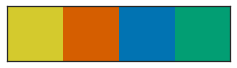

In [649]:
def shift(a, n):
    return np.array([a[(i+n)%len(a)] for i in range(len(a))])

colors = sns.color_palette('colorblind')
color_names = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'yellow', 'teal']
colors = pd.Series(colors, index=color_names)
colors['yellow'] = tuple(0.9 * np.array(colors['yellow']))
colors = colors[['yellow', 'red', 'blue', 'green']]

sns.set_palette(colors)
sns.set_context('notebook')
sns.set_style('white')

sns.palplot(colors)

In [624]:
agg_train_df['Method'] = agg_train_df['variational'].map(lambda x: ('AE', 'VAE')[x])
agg_train_df['Iteration'] = agg_train_df['iteration']

method_order = [
    'AE',
    'VAE',
]
method_order_map = {mtd: i for i, mtd in enumerate(method_order)}
agg_train_df['method_order'] = agg_train_df['Method'].map(method_order_map.__getitem__)
agg_train_df = agg_train_df.sort_values('method_order', kind='mergesort')

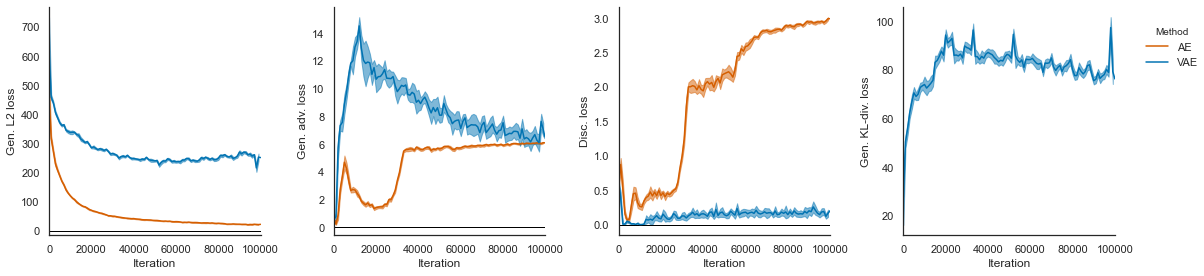

In [625]:
from collections import OrderedDict
from results import plot_lines

plot_df = agg_train_df[(agg_train_df['phase'] == 'test') &
                       (agg_train_df['iteration'] <= 100000)].copy()

k = 1000
plot_df['Iteration'] = (plot_df['iteration']//k)*k

plot_df['Gen. L2 loss']      = plot_df['gen_L2_loss']
plot_df['Gen. adv. loss']    = plot_df['gen_adv_log_loss']
plot_df['Disc. loss']        = plot_df['disc_log_loss']
plot_df['Gen. KL-div. loss'] = plot_df['gen_kldiv_loss']

plot_df['Method'] = plot_df['variational'].map(lambda x: ('AE', 'VAE')[x])

x = 'Iteration'
y = [
    'Gen. L2 loss',
    'Gen. adv. loss',
    'Disc. loss',
    'Gen. KL-div. loss',
]
hue = 'Method'
hue_order = method_order

fig = plot_lines('train_loss.png', plot_df, x=x, y=y, hue=hue, hue_order=hue_order, colors=colors[1:3],
                 n_cols=4, height=4, width=4, alpha=0.5, despine=True)

In [39]:
redund_param_names = {'expt_name', 'job_name', 'fit_options', 'variational', 'prior', 'method', 'dataset', 'cluster'}
inform_param_names = [p for p in param_names if fit_df[p].nunique() > 1 and p not in redund_param_names]

In [93]:
pd.set_option('display.max_row', 150)
pd.set_option('display.max_columns', 150)

# possible reasons for invalidity:
# n_atoms = 0
# n_frags > 1
# rdkit sanitization
#    bad explicit valence
#    failed to kekulize

error_pat = re.compile(r'.*((valence)|(kekulize)|(RingInfo)|(converged)|(bad direction)|(bad params)|(no points)).*', re.DOTALL)
def parse_error(error):
    if pd.isnull(error):
        return ' No error'
    else:
        try:
            m = error_pat.match(error)
            if m.group(2):
                return 'Explicit valence greater than permitted'
            elif m.group(3):
                return 'Failed to kekulize molecule'
            elif m.group(4):
                return 'RingInfo not initialized'
            elif m.group(5):
                return 'Minimization did not converge'
            elif m.group(6):
                return 'Bad line search direction'
            elif m.group(7):
                return 'Bad params pointer'
            elif m.group(8):
                return 'No points to minimize'
        except AttributeError as e:
            print(error)
            raise e

fit_df['lig_fit_no_atoms']            = fit_df['lig_fit_n_atoms'] == 0
fit_df['lig_fit_add_no_atoms']        = fit_df['lig_fit_n_atoms'] == 0

fit_df['lig_fit_multi_frags']         = fit_df['lig_fit_n_frags'] > 1
fit_df['lig_fit_add_multi_frags']     = fit_df['lig_fit_add_n_frags'] > 1

fit_df['lig_fit_error_type']          = fit_df['lig_fit_error'].map(parse_error)
fit_df['lig_fit_add_error_type']      = fit_df['lig_fit_add_error'].map(parse_error)
fit_df['lig_fit_add_min_error_type']  = fit_df['lig_fit_add_min_error'].map(parse_error)

error_metric_names = ['lig_fit_no_atoms', 
                      'lig_fit_multi_frags', 'lig_fit_add_multi_frags',
                      'lig_fit_error_type', 'lig_fit_add_error_type']

fit_df.groupby(error_metric_names + ['lig_fit_add_valid'])[['sample_idx']].count()

sample_idx
lig_fit_no_atoms lig_fit_multi_frags lig_fit_add_multi_frags lig_fit_error_type                      lig_fit_add_error_type                  lig_fit_add_valid            
False            False               False                    No error                                No error                               True                   474480
                                                                                                     Explicit valence greater than permitted False                   49752
                                                                                                     Failed to kekulize molecule             False                      30
                                                             Explicit valence greater than permitted  No error                               True                     6135
                                                                                                     Explicit valence greater than permitted False                   12902
                 True                False                    No error                                No error                               True                     4750
                                                                                                     Explicit valence greater than permitted False                     313
                                                             Explicit valence greater than permitted  No error                               True                        5
                                                                                                     Explicit valence greater than permitted False                     279
                                     True                     No error                                No error                               False                    1639
                                                             Explicit valence greater than permitted Explicit valence greater than permitted False                      31

In [94]:
# if there are no atoms, then n_frags == 0 and we can't fix the structure
fit_df['lig_gen_fit_no_atoms']            = fit_df['lig_gen_fit_n_atoms'] == 0
fit_df['lig_gen_fit_add_no_atoms']        = fit_df['lig_gen_fit_n_atoms'] == 0

fit_df['lig_gen_fit_multi_frags']         = fit_df['lig_gen_fit_n_frags'] > 1
fit_df['lig_gen_fit_add_multi_frags']     = fit_df['lig_gen_fit_add_n_frags'] > 1

fit_df['lig_gen_fit_error_type']          = fit_df['lig_gen_fit_error'].map(parse_error)
fit_df['lig_gen_fit_add_error_type']      = fit_df['lig_gen_fit_add_error'].map(parse_error)
fit_df['lig_gen_fit_add_error_min_type']  = fit_df['lig_gen_fit_add_min_error'].map(parse_error)

error_metric_names = [
    'lig_gen_fit_no_atoms',
    'lig_gen_fit_multi_frags',     'lig_gen_fit_error_type',
    'lig_gen_fit_add_multi_frags', 'lig_gen_fit_add_error_type'
]

fit_df.groupby(error_metric_names + ['lig_gen_fit_add_valid'])[['sample_idx']].count()

sample_idx
lig_gen_fit_no_atoms lig_gen_fit_multi_frags lig_gen_fit_error_type                  lig_gen_fit_add_multi_frags lig_gen_fit_add_error_type              lig_gen_fit_add_valid            
False                False                    No error                               False                        No error                               True                        95534
                                                                                                                 Explicit valence greater than permitted False                       14368
                                             Explicit valence greater than permitted False                        No error                               True                          692
                                                                                                                 Explicit valence greater than permitted False                        7057
                     True                     No error                               False                        No error                               True                       358699
                                                                                                                 Explicit valence greater than permitted False                       12253
                                                                                     True                         No error                               False                       22899
                                                                                                                 Explicit valence greater than permitted False                         272
                                             Explicit valence greater than permitted False                        No error                               True                          238
                                                                                                                 Explicit valence greater than permitted False                       35367
                                                                                     True                         No error                               False                           3
                                                                                                                 Explicit valence greater than permitted False                        1204
True                 False                    No error                               False                        No error                               False                        1730

In [96]:
def get_invalid_reason(row):
    ret = []
    for base in ['lig_fit',  'lig_gen_fit', 'lig_fit_add', 'lig_gen_fit_add']:
        
        reasons = []
        if row[base+'_no_atoms']:
            reasons.append('No atoms')
            
        if row[base+'_multi_frags']:
            reasons.append('Multiple disconnected fragments')
            
        if row[base+'_has_error']:
            reasons.append(row[base+'_error_type'])
            
        if reasons:
            ret.append(', '.join(reasons))
        else:
            ret.append('Valid molecule')
        
    return pd.Series(ret)

fit_df[['lig_fit_reason', 'lig_gen_fit_reason', 'lig_fit_add_reason', 'lig_gen_fit_add_reason']] \
    = fit_df.apply(get_invalid_reason, axis=1)

In [97]:
os.chdir('C:\\Users\\mtr22\\Code\\ipython-notebooks')

In [650]:
fit_df['Method'] = fit_df['method'].apply(lambda x: x.replace('_', ' '))
fit_df['Mol. sim. to train'] = fit_df['molport_sim']
fit_df['Iteration'] = fit_df['iteration']

method_order = [
    'Real density',
    'AE posterior',
    'VAE posterior',
    'VAE prior',
]
method_order_map = {mtd: i for i, mtd in enumerate(method_order)}
fit_df['method_order'] = fit_df['Method'].map(method_order_map.__getitem__)
fit_df = fit_df.sort_values('method_order', kind='mergesort')

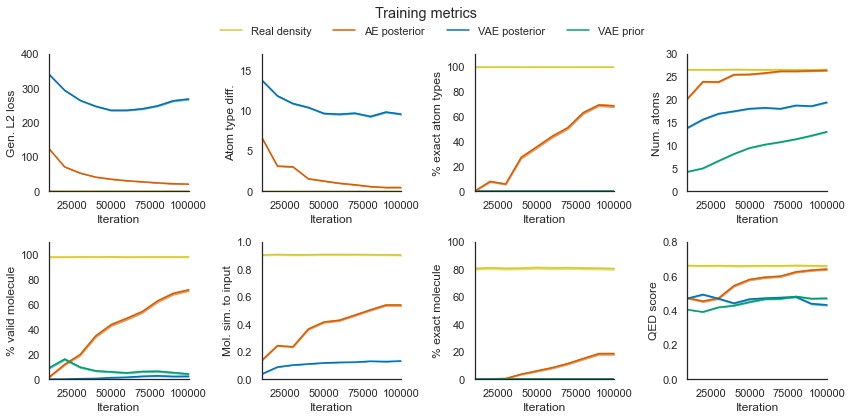

In [651]:
from results import plot_lines

plot_df = fit_df[(fit_df['dataset'] == 'molport')] # &
                 #(fit_df['prior'] == False)]

lig_plot_df = plot_df.copy()
lig_plot_df = lig_plot_df[lig_plot_df['Method'] == 'AE posterior'] # same dataset for each method, so drop duplicates
lig_gen_plot_df = plot_df.copy()

lig_plot_df['Gen. L2 loss']       = 0
lig_plot_df['Atom type diff.']    = plot_df['lig_fit_type_diff']
lig_plot_df['% exact atom types'] = (plot_df['lig_fit_type_diff'] == 0) * 100
lig_plot_df['Num. atoms']         = plot_df['lig_n_atoms']
lig_plot_df['Mol. sim. to input'] = plot_df['lig_fit_add_obfp2_sim']
lig_plot_df['% valid molecule']   = plot_df['lig_fit_valid'] * 100
lig_plot_df['% exact molecule']   = plot_df['lig_fit_add_SMILES_match'] * 100
lig_plot_df['QED score']          = plot_df['lig_QED']
lig_plot_df['Method'] = 'Real density'

lig_gen_plot_df['Gen. L2 loss']       = plot_df['lig_gen_L2_loss']
lig_gen_plot_df['Atom type diff.']    = plot_df['lig_gen_fit_type_diff']
lig_gen_plot_df['% exact atom types'] = (plot_df['lig_gen_fit_type_diff'] == 0) * 100
lig_gen_plot_df['Num. atoms']         = plot_df['lig_gen_fit_n_atoms']
lig_gen_plot_df['Mol. sim. to input'] = plot_df['lig_gen_fit_add_obfp2_sim']
lig_gen_plot_df['% valid molecule']   = plot_df['lig_gen_fit_valid'] * 100
lig_gen_plot_df['% exact molecule']   = plot_df['lig_gen_fit_add_SMILES_match'] * 100
lig_gen_plot_df['QED score']          = plot_df['lig_gen_fit_add_QED']

plot_df = pd.concat([lig_plot_df, lig_gen_plot_df])

iter_bin_size = 1
if iter_bin_size > 1:
    plot_df['Iteration'] = (plot_df['iteration']//iter_bin_size)*iter_bin_size
    
x = 'Iteration'
y = [
    'Gen. L2 loss',
    'Atom type diff.',
    '% exact atom types',
    'Num. atoms',
    '% valid molecule',
    'Mol. sim. to input',
    '% exact molecule',
    'QED score'
]
ylim = [
    (0, 400), (0, 17), (0, 110), (0, 30),
    (0, 110), (0, 1), (0, 100), (0, 0.8)
]
hue = 'Method'
hue_order = method_order

fig = plot_lines('train_fit_metrics.png', plot_df, x=x, y=y, hue=hue, hue_order=hue_order, colors=colors,
                  n_cols=4, height=3, width=3, despine=True, lead_x=0, ylim=ylim,
                  title='Training metrics', center_lgd=True, lgd_title=False)

for i, ax in enumerate(fig.axes):
    ax.set_xticks(range(0, 100001, 25000)[1:])
    ax.set_xlim(10000, 100000)


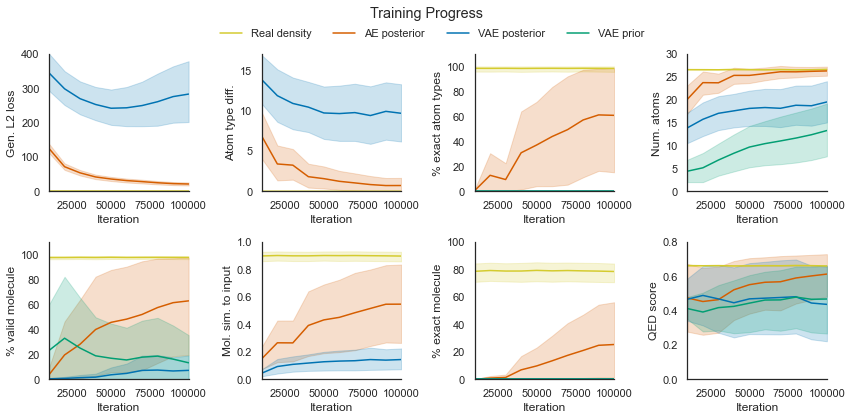

In [652]:
plot2_df = \
    plot_df.groupby([hue, x, 'lig_name']) \
    [y].agg(['max', 'mean', 'min']) \
    .groupby([hue, x]).mean().stack()

fig = plot_lines('train_fit_metrics2.png', plot2_df, x=x, y=y, hue=hue, hue_order=hue_order, colors=colors,
                  n_cols=4, height=3, width=3, despine=True, lead_x=0, ylim=ylim, range_=True, alpha=1/5,
                  title='Training Progress', center_lgd=True, lgd_title=False, lgd_h=0.895)

% valid molecules, pass 1  % valid molecules, pass 2
Method                                                                  
AE posterior  max                   76.832417                  98.686721
              mean                  52.443596                  87.852733
              min                   21.910428                  58.008755
Real density  max                   93.665409                  95.895274
              mean                  92.327491                  95.087272
              min                   87.641447                  92.289771
VAE posterior max                   42.644091                  99.641175
              mean                  11.558645                  82.405248
              min                    0.112133                  25.577484
VAE prior     max                   37.013203                 100.000000
              mean                   4.522357                  84.712083
              min                    0.000000                  19.016975

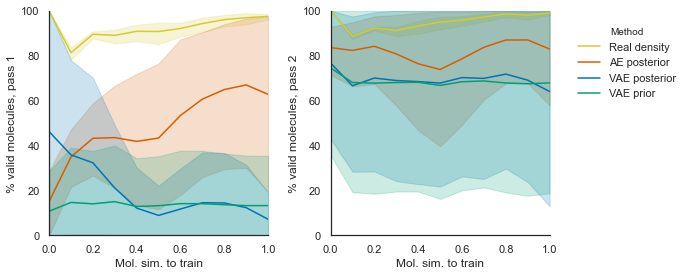

In [680]:
# NOTE the filled in areas are not the standard deviation/standard error
# and they're not the range (i.e. min and max) of the metrics being plotted,
# they are the range of the mean sample metrics- sample min, sample
# mean, and sample max, i.e. the expected sample min, mean and max
#
# for boolean metrics, e.g. lig_gen_fit_add_valid, lig_gen_fit_add_SMILES_match, etc:
# sample MAX  = ANY sample is true
# sample MEAN = FRACTION of samples that are true
# sample MIN  = ALL samples are true

plot_df = fit_df[(fit_df['iteration'] == 100000)]

lig_plot_df = plot_df.copy()
lig_gen_plot_df = plot_df.copy()

lig_plot_df['% valid molecules, pass 1'] = plot_df['lig_fit_valid'] * 100
lig_plot_df['% valid molecules, pass 2'] = (plot_df['lig_fit_valid'] | plot_df['lig_fit_add_valid']) * 100
lig_plot_df['Method'] = 'Real density'

lig_gen_plot_df['% valid molecules, pass 1'] = plot_df['lig_gen_fit_valid'] * 100
lig_gen_plot_df['% valid molecules, pass 2'] = (plot_df['lig_gen_fit_valid'] | plot_df['lig_gen_fit_add_valid']) * 100

plot_df = pd.concat([lig_plot_df, lig_gen_plot_df]).sort_values('method_order')

x = 'Mol. sim. to train'
y = ['% valid molecules, pass 1', '% valid molecules, pass 2']
hue = 'Method'
hue_order = method_order

tab_df = \
    plot_df[plot_df[x] < 1.0].groupby([hue, 'lig_name']) \
    [y].agg(['max', 'mean', 'min']) \
    .groupby([hue]).mean().stack()

plot_df = \
    plot_df.groupby([hue, x, 'lig_name']) \
    [y].agg(['max', 'mean', 'min']) \
    .groupby([hue, x]).mean().stack()

ylim  = [(0, 100)] * 2

fig = plot_lines('mol_validity2.png', plot_df, x=x, y=y, hue=hue, hue_order=hue_order, colors=colors,
                 n_cols=3, height=4, width=4, ylim=ylim, alpha=1/5,
                 despine=True, lead_x=0, range_=True)
tab_df

sample_idx  \
Method        Reason for invalid mol.                                          
AE posterior  Explicit valence greater than permitted                   8187   
              Multiple disconnected fragments                           2618   
              Multiple disconnected fragments and\nexplicit v...         189   
              Valid molecule                                           78956   
Real density  Explicit valence greater than permitted                  11246   
              Multiple disconnected fragments                           1639   
              Multiple disconnected fragments and\nexplicit v...          31   
              Valid molecule                                          256344   
VAE posterior Explicit valence greater than permitted                   9374   
              Multiple disconnected fragments                           4463   
              Multiple disconnected fragments and\nexplicit v...         306   
              No atoms                                                  1548   
              Valid molecule                                           73489   
VAE prior     Explicit valence greater than permitted                   8086   
              Multiple disconnected fragments                           5366   
              Multiple disconnected fragments and\nexplicit v...         327   
              Valid molecule                                           76351   

                                                                  % of all generated molecules  
Method        Reason for invalid mol.                                                           
AE posterior  Explicit valence greater than permitted                                 9.101723  
              Multiple disconnected fragments                                         2.910506  
              Multiple disconnected fragments and\nexplicit v...                      0.210117  
              Valid molecule                                                         87.777654  
Real density  Explicit valence greater than permitted                                 4.176632  
              Multiple disconnected fragments                                         0.608705  
              Multiple disconnected fragments and\nexplicit v...                      0.011513  
              Valid molecule                                                         95.203149  
VAE posterior Explicit valence greater than permitted                                10.511325  
              Multiple disconnected fragments                                         5.004485  
              Multiple disconnected fragments and\nexplicit v...                      0.343126  
              No atoms                                                                1.735815  
              Valid molecule                                                         82.405248  
VAE prior     Explicit valence greater than permitted                                 8.971486  
              Multiple disconnected fragments                                         5.953623  
              Multiple disconnected fragments and\nexplicit v...                      0.362809  
              Valid molecule                                                         84.712083

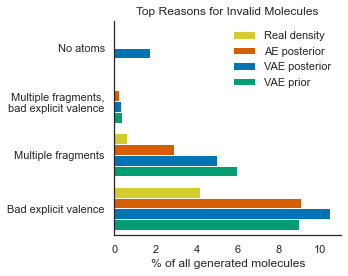

In [798]:
sns.color_palette(colors)

def fix_reason(row):
    rsn = row.iloc[0]
    if rsn != 'Valid molecule':
        rsn = row.iloc[1]
    return rsn[0].upper() + rsn[1:].replace(', ', ' and\n').lower()

plot_df = fit_df[(fit_df['iteration'] == 100000) &
                 (fit_df['dataset'] == 'pubchem')]

lig_plot_df = plot_df.copy()
lig_gen_plot_df = plot_df.copy()

lig_plot_df['Reason for invalid mol.'] = \
    plot_df[['lig_fit_reason', 'lig_fit_add_reason']].apply(fix_reason, axis=1)
lig_plot_df['Method'] = 'Real density'

lig_gen_plot_df['Reason for invalid mol.'] = \
    plot_df[['lig_gen_fit_reason', 'lig_gen_fit_add_reason']].apply(fix_reason, axis=1)

plot_df = pd.concat([lig_plot_df, lig_gen_plot_df])

plot_df = \
    plot_df.groupby(['Method', 'Reason for invalid mol.']) \
    [['sample_idx']].count()

plot_df['% of all generated molecules'] = \
    plot_df / plot_df.groupby(['Method'])[['sample_idx']].agg('sum') * 100

tab_df = plot_df

plot_df = plot_df.reset_index()

reason_order = [
    'Valid molecule',
    'Explicit valence greater than permitted',
    'Multiple disconnected fragments',
    'Multiple disconnected fragments and\nexplicit valence greater than permitted',
    'Failed to kekulize molecule',
    'No atoms',
][::-1]
reason_order_map = {rsn: i for i, rsn in enumerate(reason_order)}

plot_df['reason_order'] = plot_df['Reason for invalid mol.'].map(reason_order_map.__getitem__)

abbrev_reason = {
    'Valid molecule': 'Valid',
    'Explicit valence greater than permitted': 'Bad explicit valence',
    'Multiple disconnected fragments': 'Multiple fragments',
    'Multiple disconnected fragments and\nexplicit valence greater than permitted': 'Multiple fragments,\nbad explicit valence',
    'Failed to kekulize molecule': 'Failed to Kekulize',
    'No atoms': 'No atoms'
}
plot_df['Reason for invalid mol.'] = plot_df['Reason for invalid mol.'].map(abbrev_reason.__getitem__)

plot_df = plot_df.sort_values('reason_order', kind='mergesort')

phi = (1 + np.sqrt(5))/2
fig, axes = plt.subplots(1, 1, figsize=(5, 4)) #, gridspec_kw=dict(width_ratios=[phi, 1]))

# bar plot of reasons for invalid molecules
ax = axes #[0]
sns.barplot(x='% of all generated molecules',
            y='Reason for invalid mol.',
            hue='Method',
            hue_order=method_order,
            data=plot_df[plot_df['Reason for invalid mol.'] != 'Valid'],
            saturation=1.0, ax=ax)

#ax.set_xlim(0, 20)
ax.legend(loc='upper right', frameon=False, title=None)
ax.set_title('Top Reasons for Invalid Molecules', fontsize='medium')
#ax.title.set_position([0.5, 1.05])
ax.set_ylabel('')

if False:
    # line plot of mol validity wrt sampling
    ax = axes[1]

    plot_df = fit_df[(fit_df['iteration'] == 100000)]

    lig_plot_df = plot_df.copy()
    lig_gen_plot_df = plot_df.copy()

    lig_plot_df['% valid molecules'] = (plot_df['lig_fit_valid'] | plot_df['lig_fit_add_valid']) * 100
    lig_plot_df['Method'] = 'Real density'

    lig_gen_plot_df['% valid molecules'] = (plot_df['lig_gen_fit_valid'] | plot_df['lig_gen_fit_add_valid']) * 100
    #lig_gen_plot_df['Method'] = 'Generated'

    plot_df = pd.concat([lig_plot_df, lig_gen_plot_df])

    plot_df = pd.concat([lig_plot_df, lig_gen_plot_df])

    # this is a hack to get the inital point in the sampling plot
    init_df = pd.DataFrame({
        'Method': ['Real density', 'AE posterior', 'VAE posterior', 'VAE prior'],
        'lig_name': ['dummy', 'dummy', 'dummy', 'dummy'],
        'sample_idx': [-1, -1, -1, -1],
        '% valid molecules': [False, False, False, False]
    })
    #plot_df = init_df.append(plot_df)


    plot_df['% molecules with any valid sample'] = \
        plot_df.groupby(['Method', 'lig_name'])[['% valid molecules']].cummax()

    plot_df['# samples'] = plot_df['sample_idx'] + 1

    sns.lineplot(x='# samples',
                 y='% molecules with any valid sample',
                 hue='Method',
                 data=plot_df, ax=ax)


    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles[1:], labels=labels[1:], loc='lower right', frameon=False, title=None)
    ax.set_title('2. Sampling Valid Molecules')

    ax.set_xlim(1, 10)
    ax.set_ylim(0, 110)
    ax.set_xticks(range(1, 11, 2))

    #fig.suptitle('Validity of Generated Molecules')

sns.despine(fig)
fig.tight_layout(rect=[0, 0, 1, 1])
fig.savefig('mol_validity_bars.png')

tab_df

Mol. sim. to train % exact atom types % exact molecule  \
                                   mean               mean             mean   
Method       level_2                                                          
AE posterior max                   0.45          60.834928        29.836554   
             mean                  0.45          40.005808        11.501959   
             min                   0.45          12.210383         1.071796   
Real density max                   0.45          99.532530        84.918650   
             mean                  0.45          97.186649        77.986457   
             min                   0.45          90.278281        66.697083   

                     Atom-only RMSD Bonded RMSD method_order  
                               mean        mean         mean  
Method       level_2                                          
AE posterior max           0.346085    0.249498            1  
             mean          0.282049    0.213665            1  
             min           0.231184    0.186875            1  
Real density max           0.037468    0.032099            0  
             mean          0.010135    0.010094            0  
             min           0.001440    0.001350            0

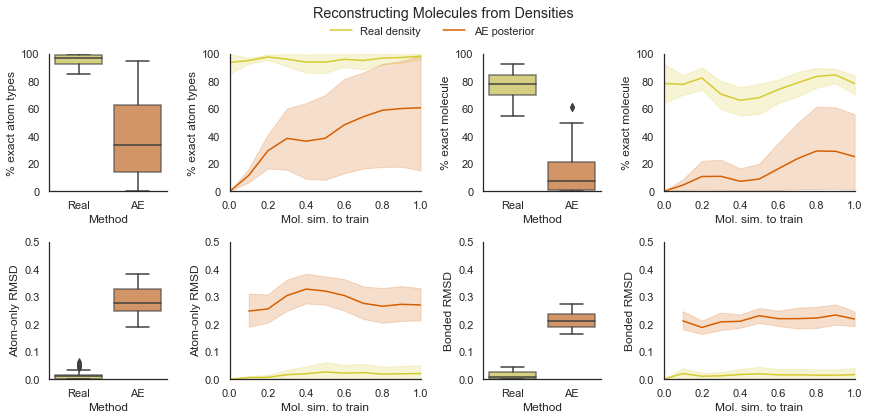

In [656]:
from results import plot_lines

# to demonstrate effectivesness of atom fitting on ideal densities,
# show % time we fit exact atom types, then rmsd to true coords (no bonds),
# then % of time we add correct bonds, then rmsd to true molecule

plot_df = fit_df[(fit_df['iteration'] == 100000) &
                     (fit_df['variational'] == False) &
                     (fit_df['prior'] == False)].copy()

plot_df['Mol. sim. to train'] = plot_df['molport_sim']

lig_plot_df = plot_df.copy()
lig_gen_plot_df = plot_df.copy()

lig_plot_df['% exact atom types'] = (plot_df['lig_fit_type_diff'] == 0).astype(int) * 100
lig_plot_df['% exact molecule']   = plot_df['lig_fit_add_SMILES_match'].astype(int) * 100
lig_plot_df['Atom-only RMSD']     = plot_df['lig_fit_RMSD']
lig_plot_df['Bonded RMSD']        = plot_df['lig_fit_add_RMSD_true']
lig_plot_df['Method'] = 'Real density'

lig_gen_plot_df['% exact atom types'] = (plot_df['lig_gen_fit_type_diff'] == 0).astype(int) * 100
lig_gen_plot_df['% exact molecule']   = plot_df['lig_gen_fit_add_SMILES_match'].astype(int) * 100
lig_gen_plot_df['Atom-only RMSD']     = plot_df['lig_gen_fit_RMSD']
lig_gen_plot_df['Bonded RMSD']        = plot_df['lig_gen_fit_add_RMSD_true']

plot_df = pd.concat([lig_plot_df, lig_gen_plot_df])

y = [
    '% exact atom types', '% exact molecule',
    'Atom-only RMSD',     'Bonded RMSD',
]

# mean of sample min, mean, and max
plot_df = plot_df \
    .groupby(['Method', 'Mol. sim. to train', 'lig_name'])[y] \
    .agg(['min', 'mean', 'max']) \
    .groupby(['Method', 'Mol. sim. to train']) \
    .mean().stack().reset_index()

# the previous command changes method order
plot_df['method_order'] = plot_df['Method'].map(method_order_map.__getitem__)
plot_df = plot_df.sort_values('method_order', kind='mergesort')

x = 'Mol. sim. to train'

y = [
    None, y[0], None, y[1],
    None, y[2], None, y[3],
]
ylim = [(0, 100)]*4 \
     + [(0, 0.5)]*4

hue = 'Method'
hue_order = method_order[:2]

fig = plot_lines('atom_fitting_recon.png', plot_df, x=x, y=y, hue=hue, hue_order=hue_order, colors=colors[:2],
                 n_cols=4, height=3, width=3, ylim=ylim, alpha=1/5,
                 despine=True, lead_x=0, range_=True, gridspec_kw=dict(width_ratios=[1, phi, 1, phi]),
                 title='Reconstructing Molecules from Densities', center_lgd=True, lgd_title=False)

plot_df = plot_df[plot_df['Mol. sim. to train'] < 1.0]

ax = fig.axes[0]
sns.boxplot(y='% exact atom types', x=hue, data=plot_df,
            boxprops=dict(alpha=2/3), ax=ax)
ax.set_ylim(0, 100)
ax.set_xticklabels(['Real', 'AE'])

ax = fig.axes[2]
sns.boxplot(y='% exact molecule', x=hue, data=plot_df,
            boxprops=dict(alpha=2/3), ax=ax)
ax.set_ylim(0, 100)
ax.set_xticklabels(['Real', 'AE'])

ax = fig.axes[4]
sns.boxplot(y='Atom-only RMSD', x=hue, data=plot_df,
            boxprops=dict(alpha=2/3), ax=ax)
ax.set_ylim(0, 0.5)
ax.set_xticklabels(['Real', 'AE'])

ax = fig.axes[6]
sns.boxplot(y='Bonded RMSD', x=hue, data=plot_df,
            boxprops=dict(alpha=2/3), ax=ax)
ax.set_ylim(0, 0.5)
ax.set_xticklabels(['Real', 'AE'])

lgd = fig.axes[-1].get_legend()
fig.savefig('atom_fitting_recon.png', bbox_inches='tight')

plot_df.groupby([hue, 'level_2']).agg(['mean']) #.stack().transpose().unstack()

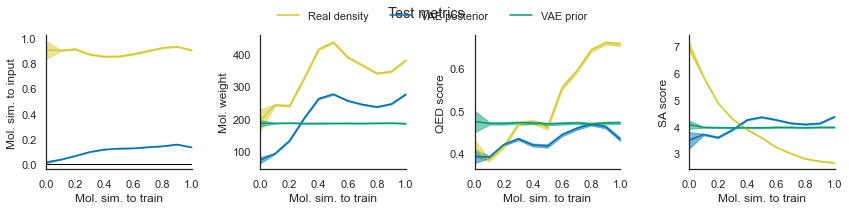

In [657]:
from results import plot_lines

plot_df = fit_df[(fit_df['iteration'] == 100000) &
                 (fit_df['variational'])]

lig_plot_df = plot_df.copy()
lig_plot_df = lig_plot_df[lig_plot_df['Method'] == 'VAE posterior'] # same dataset for each method, so drop duplicates
lig_gen_plot_df = plot_df.copy()

lig_plot_df['Gen. L2 loss']       = 0
lig_plot_df['Atom type diff.']    = lig_plot_df['lig_fit_type_diff']
lig_plot_df['% exact atom types'] = (lig_plot_df['lig_fit_type_diff'] == 0)
lig_plot_df['Num. atoms']         = lig_plot_df['lig_n_atoms']
lig_plot_df['Mol. sim. to input'] = lig_plot_df['lig_fit_add_obfp2_sim']
lig_plot_df['% valid molecule']   = lig_plot_df['lig_fit_valid']
lig_plot_df['% exact molecule']   = lig_plot_df['lig_fit_add_SMILES_match']
lig_plot_df['Mol. weight']        = lig_plot_df['lig_fit_add_MW']
lig_plot_df['QED score']                = lig_plot_df['lig_fit_add_QED']
lig_plot_df['SA score']                = lig_plot_df['lig_fit_add_SAS']
lig_plot_df['NPS']                = lig_plot_df['lig_fit_add_NPS']
lig_plot_df['Method'] = 'Real density'

lig_gen_plot_df['Gen. L2 loss']       = lig_gen_plot_df['lig_gen_L2_loss']
lig_gen_plot_df['Atom type diff.']    = lig_gen_plot_df['lig_gen_fit_type_diff']
lig_gen_plot_df['% exact atom types'] = (lig_gen_plot_df['lig_gen_fit_type_diff'] == 0)
lig_gen_plot_df['Num. atoms']         = lig_gen_plot_df['lig_gen_fit_n_atoms']
lig_gen_plot_df['Mol. sim. to input'] = lig_gen_plot_df['lig_gen_fit_add_obfp2_sim']
lig_gen_plot_df['% valid molecule']   = lig_gen_plot_df['lig_gen_fit_valid']
lig_gen_plot_df['% exact molecule']   = lig_gen_plot_df['lig_gen_fit_add_SMILES_match']
lig_gen_plot_df['Mol. weight']        = lig_gen_plot_df['lig_gen_fit_add_MW']
lig_gen_plot_df['QED score']                = lig_gen_plot_df['lig_gen_fit_add_QED']
lig_gen_plot_df['SA score']                = lig_gen_plot_df['lig_gen_fit_add_SAS']
lig_gen_plot_df['NPS']                = lig_gen_plot_df['lig_gen_fit_add_NPS']


plot_df = pd.concat([lig_plot_df, lig_gen_plot_df])

x = 'Mol. sim. to train'
y = [
    'Mol. sim. to input',
    'Mol. weight',
    'QED score',
    'SA score',
]
hue = 'Method'

hue_order = [method_order[0], method_order[2], method_order[3]]
_colors    = np.array([colors[0], colors[2], colors[3]])

fig = plot_lines('test_fit_metrics.png', plot_df, x=x, y=y, hue=hue, hue_order=hue_order, colors=_colors,
                  n_cols=4, height=3, width=3, despine=True, lead_x=0, #ylim=ylim,
                  title='Test metrics', center_lgd=True, lgd_title=False)

for i, ax in enumerate(fig.axes):
    xticks = np.arange(0, 1.1, 0.2)
    ax.set_xticks(xticks)
    ax.set_xticklabels(['%.1f'%xt for xt in xticks])
    ax.set_xlim(0.0, 1.0)


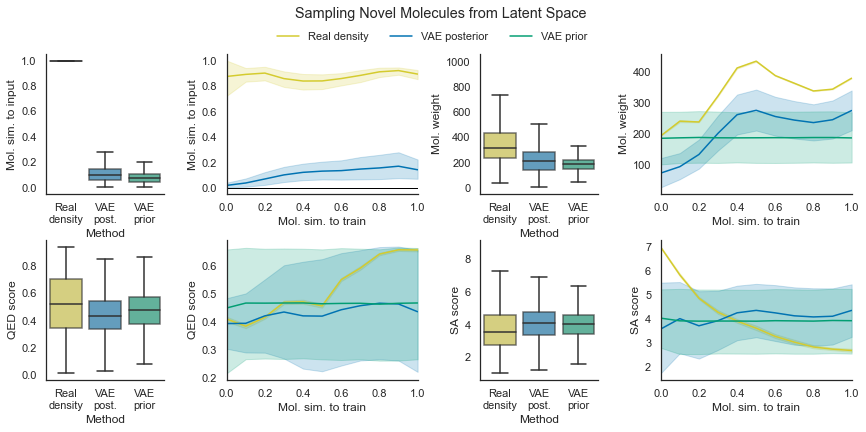

In [658]:
plot2_df = \
    plot_df.groupby([hue, x, 'lig_name']) \
    [y].agg(['max', 'mean', 'min']) \
    .groupby([hue, x]).mean().stack()

x = 'Mol. sim. to train'
_y = [
    None, 'Mol. sim. to input',
    None, 'Mol. weight',
    None, 'QED score',
    None, 'SA score',
]
hue = 'Method'

fig = plot_lines('test_fit_metrics2.png', plot2_df, x=x, y=_y, hue=hue, hue_order=_hue_order, colors=_colors,
                  n_cols=4, height=3, width=3, despine=True, lead_x=0, range_=True, alpha=1/5, #ylim=ylim,
                  title='Sampling Novel Molecules from Latent Space', center_lgd=True, lgd_title=False,
                  gridspec_kw=dict(width_ratios=[1, phi, 1, phi]), lgd_h=0.915)

plot3_df = plot_df[plot_df['dataset'] == 'pubchem']

for i, ax in enumerate(fig.axes):
    if i%2 == 0:
        sns.boxplot(y=_y[i+1], x=hue, data=plot3_df,
                    boxprops=dict(alpha=2/3), fliersize=0, palette=_colors, ax=ax)
        ax.set_xticklabels(['Real\ndensity', 'VAE\npost.', 'VAE\nprior'])
    else:
        xticks = np.arange(0, 1.1, 0.2)
        ax.set_xticks(xticks)
        ax.set_xticklabels(['%.1f'%xt for xt in xticks])
        ax.set_xlim(0.0, 1.0)

fig.savefig('latent_sampling.png', bbox_inches='tight')

In [ ]:
seed = 564813

564813


c:\users\mtr22\code\miniconda3\lib\site-packages\ipykernel_launcher.py:70: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


'C:\\Users\\mtr22\\Code\\ipython-notebooks'

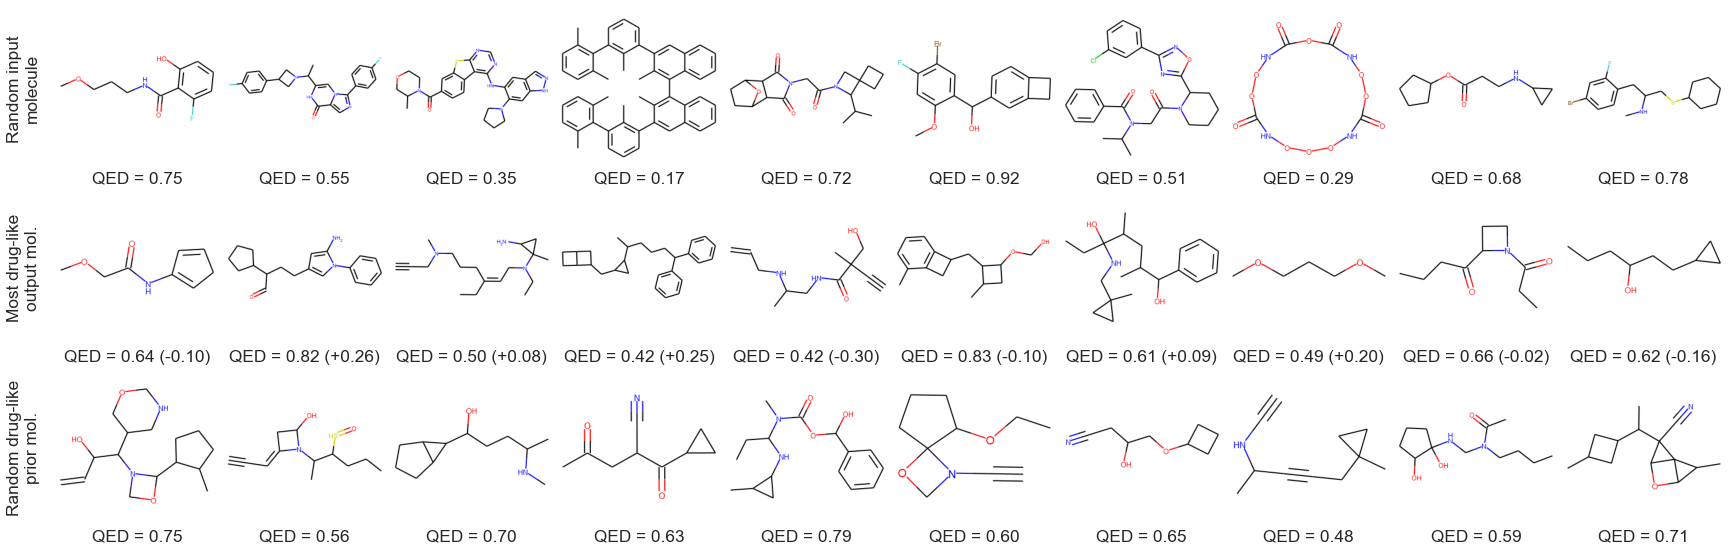

In [784]:
import matplotlib.image as mpimg

def smi_to_image(smi):
    mol = Chem.MolFromSmiles(smi)
    return Chem.Draw.MolToImage(mol)

mol_df = fit_df[(fit_df['dataset'] == 'pubchem') &
                (fit_df['iteration'] == 100000)  &
                (fit_df['variational'] == True) &
                (fit_df['prior'] == False)].copy()

mol_df = mol_df[mol_df['lig_fit_add_valid'] & mol_df['lig_gen_fit_add_valid']]
mol_df['Change in QED'] = mol_df['lig_gen_fit_add_QED'] - mol_df['lig_QED']

n_mols = 10

print(seed)
np.random.seed(seed)
mols = mol_df['lig_name'].unique()
np.random.shuffle(mols)
mols = set(mols[:n_mols])
mol_df = mol_df[mol_df['lig_name'].map(mols.__contains__)]
mol_df = mol_df[~mol_df['Change in QED'].isna()].reset_index()
mol_df = mol_df.iloc[mol_df.groupby('lig_name')['Change in QED'].idxmax()]
mol_df['lig_im'] = mol_df['lig_SMILES'].map(smi_to_image)
mol_df['lig_fit_add_im'] = mol_df['lig_fit_add_SMILES'].map(smi_to_image)
mol_df['lig_gen_fit_add_im'] = mol_df['lig_gen_fit_add_SMILES'].map(smi_to_image)
mol_df

pri_df = fit_df[(fit_df['dataset'] == 'pubchem') &
                (fit_df['iteration'] == 100000)  &
                (fit_df['variational'] == True) &
                (fit_df['prior'] == True)].copy()
pri_df = pri_df[pri_df['lig_name'].map(mols.__contains__)]
pri_df = pri_df[pri_df['lig_gen_fit_add_valid'] & (~pri_df['lig_gen_fit_add_QED'].isna())].reset_index()
pri_df = pri_df.iloc[pri_df.groupby('lig_name')['lig_gen_fit_add_QED'].idxmax()]
pri_df['lig_gen_fit_add_im'] = pri_df['lig_gen_fit_add_SMILES'].map(smi_to_image)
pri_df

n_ims = 3
ims = ['lig_fit_add_im', 'lig_gen_fit_add_im', 'lig_gen_fit_add_im']
qeds = ['lig_fit_add_QED', 'lig_gen_fit_add_QED', 'lig_gen_fit_add_QED']

n_rows = n_ims*2
n_cols = n_mols
width = height = 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(width*n_cols, height*n_rows//2 * 1.1),
                         gridspec_kw=dict(height_ratios=[10, 1, 10, 1, 10, 1]))

for mol_idx in range(n_mols):
    post_row = mol_df.iloc[mol_idx]
    pri_row = pri_df.iloc[mol_idx]
    for im_idx in range(n_ims):
        
        if im_idx == 2:
            row = pri_row
        else:
            row = post_row
            
        im = row[ims[im_idx]]
        qed = row[qeds[im_idx]]

        ax = axes[2*im_idx, mol_idx]
        ax.imshow(im, aspect='auto')
        
        ax = axes[2*im_idx+1, mol_idx]
        text = 'QED = {:.2f}'.format(qed)
        if im_idx == 1:
            qed_imp = row['Change in QED']
            text += ' ({}{:.2f})'.format(['', '+'][qed_imp>0], qed_imp)
        ax.text(0.5, 0.5, text, transform=ax.transAxes, 
                horizontalalignment='center', verticalalignment='center', fontsize='x-large')

for ax in axes.flatten():
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
axes[0,0].set_ylabel('Random input\nmolecule', fontsize='x-large')
axes[2,0].set_ylabel('Most drug-like\noutput mol.', fontsize='x-large')
axes[4,0].set_ylabel('Random drug-like\nprior mol.', fontsize='x-large')
    
sns.despine(fig, top=True, bottom=True, left=True, right=True)
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig('vae_post_mols.png', bbox_inches='tight')
os.getcwd()

In [783]:
seed = int(np.random.rand() * 1000000) # 958772 653066

In [451]:
lat_df = fit_df[(fit_df['dataset'] == 'molport') &
                (fit_df['iteration'] == 100000)  &
                (fit_df['variational'] == False) &
                (fit_df['prior'] == False)]

lat_df.sort_values('lig_gen_fit_add_QED', ascending=False)

,Unnamed: 0,lig_name,sample_idx,lig_norm,lig_gen_norm,lig_latent_norm,lig_gen_L2_loss,lig_variance,lig_gen_variance,lig_fit_L2_loss,lig_n_atoms,lig_fit_n_atoms,lig_radius,lig_fit_radius,lig_fit_type_diff,lig_fit_RMSD,lig_fit_time,lig_gen_fit_L2_loss,lig_gen_fit_n_atoms,lig_gen_fit_radius,lig_gen_fit_type_diff,lig_gen_fit_RMSD,lig_gen_fit_time,lig_n_frags,lig_error,lig_valid,lig_fit_n_frags,lig_fit_error,lig_fit_valid,lig_fit_add_n_frags,lig_fit_add_error,lig_fit_add_valid,lig_SMILES,lig_fit_add_SMILES,lig_fit_add_SMILES_match,lig_fit_add_morgan_sim,lig_fit_add_rdkit_sim,lig_fit_add_maccs_sim,lig_MW,lig_logP,lig_QED,lig_SAS,lig_NPS,lig_fit_add_MW,lig_fit_add_logP,lig_fit_add_QED,lig_fit_add_SAS,lig_fit_add_NPS,lig_E,lig_min_E,lig_dE_min,lig_min_error,lig_RMSD_min,lig_fit_add_E,lig_fit_add_min_E,lig_fit_add_dE_min,lig_fit_add_min_error,lig_fit_add_RMSD_min,lig_fit_add_dE_true,lig_fit_add_min_dE_true,lig_fit_add_RMSD_true,lig_fit_add_min_RMSD_true,lig_gen_fit_n_frags,lig_gen_fit_error,lig_gen_fit_valid,lig_gen_fit_add_n_frags,lig_gen_fit_add_error,lig_gen_fit_add_valid,lig_gen_fit_add_SMILES,lig_gen_fit_add_SMILES_match,lig_gen_fit_add_morgan_sim,lig_gen_fit_add_rdkit_sim,lig_gen_fit_add_maccs_sim,lig_gen_fit_add_MW,lig_gen_fit_add_logP,lig_gen_fit_add_QED,lig_gen_fit_add_SAS,lig_gen_fit_add_NPS,lig_gen_fit_add_E,lig_gen_fit_add_min_E,lig_gen_fit_add_dE_min,lig_gen_fit_add_min_error,lig_gen_fit_add_RMSD_min,lig_gen_fit_add_dE_true,lig_gen_fit_add_min_dE_true,lig_gen_fit_add_RMSD_true,lig_gen_fit_add_min_RMSD_true,job_name,array_idx,expt_name,cluster,dataset,variational,gen_loss_type,disc_loss_type,random_seed,fit_options,prior,random_rotation,constrain_types,atom_init,AE/VAE,posterior/prior,method,molport_sim,iteration,lig_fit_has_error,lig_gen_fit_has_error,lig_fit_add_has_error,lig_fit_add_min_has_error,lig_gen_fit_add_has_error,lig_gen_fit_add_min_has_error,lig_fit_add_dvalid,lig_gen_fit_add_dvalid,lig_logE,lig_min_logE,lig_dlogE_min,lig_gen_fit_add_logE,lig_gen_fit_add_min_logE,lig_gen_fit_add_dlogE_min,lig_gen_fit_add_dlogE_true,lig_gen_fit_add_min_dlogE_true,lig_fit_add_obfp2_sim,lig_gen_fit_add_obfp2_sim,lig_fit_no_atoms,lig_fit_add_multi_frags,lig_fit_error_type,lig_fit_add_error_type,lig_fit_add_min_error_type,lig_gen_fit_no_atoms,lig_gen_fit_multi_frags,lig_gen_fit_add_multi_frags,lig_gen_fit_error_type,lig_gen_fit_add_error_type,lig_gen_fit_add_error_min_type,lig_fit_add_reason,lig_gen_fit_add_reason,Method,Mol. sim. to train,Iteration,method_order,lig_fit_add_no_atoms,lig_gen_fit_add_no_atoms,lig_fit_multi_frags,lig_fit_reason,lig_gen_fit_reason
86582,2,2054212_2,2,33.719921,33.238445,0.340807,8.466222,816.683716,796.972595,0.000149,21.0,21.0,4.979565,4.979708,0.0,0.001166,19.011119,4.292871,21.0,5.034244,0.0,0.154849,18.971103,1.0,NaN,True,1.0,NaN,True,1.0,NaN,True,Cc1ccc(F)cc1NC(=O)c1ccccc1S(C)(=O)=O,Cc1ccc(F)cc1NC(=O)c1ccccc1S(C)(=O)=O,True,1.000000,1.000000,1.000000,307.346,2.78992,0.948100,1.756797,-2.261978,307.346,2.78992,0.9481,1.756797,-2.261978,66.823889,43.974142,-22.849748,NaN,0.438765,66.875310,43.974142,-22.901168,NaN,4.387505e-01,0.051420,-2.132283e-08,0.001151,0.000014,1.0,NaN,True,1.0,NaN,True,Cc1ccc(F)cc1NC(=O)c1ccccc1S(C)(=O)=O,True,1.000000,1.000000,1.000000,307.346,2.78992,0.9481,1.756797,-2.261978,469.352362,43.974142,-425.378221,NaN,4.607011e-01,402.528549,-2.258529e-08,0.149705,0.000019,ae_disc_x_0_100000_r_none,179,csb_molport2,csb,molport,False,e,x,0,r,False,True,False,none,AE,posterior,AE_posterior,1.0,100000,False,False,False,False,False,False,0,0,1.824932,1.643197,-0.181734,2.671499,1.643197,-1.028302,0.846567,-2.231744e-10,1.000000,1.000000,False,False,No error,No error,No error,False,False,False,No error,No error,No error,Valid molecule,Valid molecule,AE posterior,1.0,100000,1,False,False,False,Valid molecule,Valid molecule
86581,1,2054212_2,1,33.720146,33.726227,0.349937,9.585426,726.693787,729.750000,0.000076,21.0,21.0,4.979565,4.979663,0.0,0.000744,19.099331,5.480505,21.0,5.020443,0.0

In [517]:
lat_df = fit_df[(fit_df['dataset'] == 'molport') &
                (fit_df['iteration'] == 100000)  &
                (fit_df['variational'] == True) &
                (fit_df['prior'] == False)]

lat_df.sort_values('lig_gen_fit_add_QED', ascending=False)

,Unnamed: 0,lig_name,sample_idx,lig_norm,lig_gen_norm,lig_latent_norm,lig_gen_L2_loss,lig_variance,lig_gen_variance,lig_fit_L2_loss,lig_n_atoms,lig_fit_n_atoms,lig_radius,lig_fit_radius,lig_fit_type_diff,lig_fit_RMSD,lig_fit_time,lig_gen_fit_L2_loss,lig_gen_fit_n_atoms,lig_gen_fit_radius,lig_gen_fit_type_diff,lig_gen_fit_RMSD,lig_gen_fit_time,lig_n_frags,lig_error,lig_valid,lig_fit_n_frags,lig_fit_error,lig_fit_valid,lig_fit_add_n_frags,lig_fit_add_error,lig_fit_add_valid,lig_SMILES,lig_fit_add_SMILES,lig_fit_add_SMILES_match,lig_fit_add_morgan_sim,lig_fit_add_rdkit_sim,lig_fit_add_maccs_sim,lig_MW,lig_logP,lig_QED,lig_SAS,lig_NPS,lig_fit_add_MW,lig_fit_add_logP,lig_fit_add_QED,lig_fit_add_SAS,lig_fit_add_NPS,lig_E,lig_min_E,lig_dE_min,lig_min_error,lig_RMSD_min,lig_fit_add_E,lig_fit_add_min_E,lig_fit_add_dE_min,lig_fit_add_min_error,lig_fit_add_RMSD_min,lig_fit_add_dE_true,lig_fit_add_min_dE_true,lig_fit_add_RMSD_true,lig_fit_add_min_RMSD_true,lig_gen_fit_n_frags,lig_gen_fit_error,lig_gen_fit_valid,lig_gen_fit_add_n_frags,lig_gen_fit_add_error,lig_gen_fit_add_valid,lig_gen_fit_add_SMILES,lig_gen_fit_add_SMILES_match,lig_gen_fit_add_morgan_sim,lig_gen_fit_add_rdkit_sim,lig_gen_fit_add_maccs_sim,lig_gen_fit_add_MW,lig_gen_fit_add_logP,lig_gen_fit_add_QED,lig_gen_fit_add_SAS,lig_gen_fit_add_NPS,lig_gen_fit_add_E,lig_gen_fit_add_min_E,lig_gen_fit_add_dE_min,lig_gen_fit_add_min_error,lig_gen_fit_add_RMSD_min,lig_gen_fit_add_dE_true,lig_gen_fit_add_min_dE_true,lig_gen_fit_add_RMSD_true,lig_gen_fit_add_min_RMSD_true,job_name,array_idx,expt_name,cluster,dataset,variational,gen_loss_type,disc_loss_type,random_seed,fit_options,prior,random_rotation,constrain_types,atom_init,AE/VAE,posterior/prior,method,molport_sim,iteration,lig_fit_has_error,lig_gen_fit_has_error,lig_fit_add_has_error,lig_fit_add_min_has_error,lig_gen_fit_add_has_error,lig_gen_fit_add_min_has_error,lig_fit_add_dvalid,lig_gen_fit_add_dvalid,lig_logE,lig_min_logE,lig_dlogE_min,lig_gen_fit_add_logE,lig_gen_fit_add_min_logE,lig_gen_fit_add_dlogE_min,lig_gen_fit_add_dlogE_true,lig_gen_fit_add_min_dlogE_true,lig_fit_add_obfp2_sim,lig_gen_fit_add_obfp2_sim,lig_fit_no_atoms,lig_fit_add_multi_frags,lig_fit_error_type,lig_fit_add_error_type,lig_fit_add_min_error_type,lig_gen_fit_no_atoms,lig_gen_fit_multi_frags,lig_gen_fit_add_multi_frags,lig_gen_fit_error_type,lig_gen_fit_add_error_type,lig_gen_fit_add_error_min_type,lig_fit_add_reason,lig_gen_fit_add_reason,Method,Mol. sim. to train,Iteration,method_order,lig_fit_add_no_atoms,lig_gen_fit_add_no_atoms,lig_fit_multi_frags,lig_fit_reason,lig_gen_fit_reason
270540,4,1063564_15,4,47.074955,45.577454,32.377304,247.258331,1625.902954,1507.616089,0.002734,28.0,28.0,7.873607,7.870922,0.0,0.034128,22.986877,19.548965,22.0,7.013309,6.0,NaN,17.596073,1.0,NaN,True,1.0,NaN,True,1.0,NaN,True,O=C(COC(=O)c1ccccc1C(F)(F)F)c1ccc(-c2ccccc2)cc1,O=C(COC(=O)c1ccccc1C(F)(F)F)c1ccc(-c2ccccc2)cc1,True,1.000000,1.000000,1.000000,384.353,5.41210,0.436257,1.862699,-0.905013,384.353,5.41210,0.436257,1.862699,-0.905013,102.947455,59.899274,-43.048181,NaN,0.621179,120.285463,59.899274,-60.386189,NaN,6.235317e-01,17.338008,-9.413895e-08,0.033150,0.000095,2.0,NaN,False,1.0,NaN,True,OC1(c2ccc(C3=CCC=C3)cc2)COC(C2CCCC2)O1,False,0.083333,0.405333,0.340909,298.382,3.73810,0.923637,3.906017,1.346516,750870.512454,58.589568,-750811.922886,NaN,1.184255e+00,750767.564998,-1.309706,NaN,NaN,gen_e_disc_x_0_100000_r_none,735,csb_molport2,csb,molport,True,e,x,0,r,False,True,False,none,VAE,posterior,VAE_posterior,1.0,100000,False,False,False,False,False,False,0,1,2.012616,1.777422,-0.235194,5.875565,1.767820,-4.107745,3.862949,-0.009601,1.000000,0.305344,False,False,No error,No error,No error,False,True,False,No error,No error,No error,Valid molecule,Valid molecule,VAE posterior,1.0,100000,2,False,False,False,Valid molecule,Multiple disconnected fragments
265033,7,743176_4,7,38.298473,38.111191,30.877642,235.575821,1080.158081,987.177063,0.000074,25.0,25.0,6.842743,6.84266

In [595]:
latent_dir = 'C:\\Users\\mtr22\\3D Objects\\gen_paper'

latent_metrics_files = [
    'ae_disc_x_0_100000_rsi_pose_interp_rand\\latent_interp1.gen_metrics',
    'gen_e_disc_x_0_100000_rsi_pose_interp_rand\\latent_interp1.gen_metrics',
    'ae_disc_x_0_100000_rsi_pubchem_diff0.5_head_10\\latent_interp1.gen_metrics',
    'gen_e_disc_x_0_100000_rsi_pubchem_diff0.5_head_10\\latent_interp1.gen_metrics',
]
latent_names = [
    'ae_pose_interp1_2_3',
    'gen_e_pose_interp1_8_9',
    'ae_latent_interp1_8_9',
    'gen_e_latent_interp1_6_7',
]
interp_ligs = [
    ('2054212_1', '2054212_2'),
    ('2054212_4', '2054212_5'),
    ('PubChem-121314654_0', 'PubChem-79970953_0'),
    ('PubChem-118526673_0',  'PubChem-118185755_0')
]

lat_dfs = []
for i, latent_metrics_file in enumerate(latent_metrics_files):
    lat_df = pd.read_csv(latent_dir + '\\fixed_batch_size\\' + latent_metrics_file, sep=' ')
    lat_df['job_name'] = os.path.dirname(latent_metrics_file).rsplit('_', 2)[0]
    lat_df['latent_idx'] = i
    lat_df['latent_name'] = latent_names[i]
    lig0, lig1 = interp_ligs[i]
    cond = (lig0 == lat_df['lig_name']) | (lig1 == lat_df['lig_name'])
    assert cond.any(), (latent_names[i], interp_ligs[i])
    lat_dfs.append(lat_df[cond])

lat_df = pd.concat(lat_dfs)
lat_df[job_param_names] = lat_df['job_name'].apply(parse_job_name)

lat_df.groupby(['latent_name', 'lig_name'])[['sample_idx']].count()

sample_idx
latent_name              lig_name                       
ae_latent_interp1_8_9    PubChem-121314654_0          10
                         PubChem-79970953_0           10
ae_pose_interp1_2_3      2054212_1                    10
                         2054212_2                    10
gen_e_latent_interp1_6_7 PubChem-118185755_0          10
                         PubChem-118526673_0          10
gen_e_pose_interp1_8_9   2054212_4                    10
                         2054212_5                    10

In [596]:
lat_df['interp_idx'] = 1
lat_df['interp_idx'] = lat_df.groupby('latent_name')['interp_idx'].cumsum() - 1
lat_df['lig_idx'] = lat_df['interp_idx'] // 10 # n_samples
lat_df.set_index('latent_name')

,lig_name,sample_idx,lig_norm,lig_gen_norm,lig_latent_norm,lig_gen_L2_loss,lig_variance,lig_gen_variance,lig_fit_L2_loss,lig_n_atoms,lig_fit_n_atoms,lig_radius,lig_fit_radius,lig_fit_type_diff,lig_fit_RMSD,lig_fit_time,lig_gen_fit_L2_loss,lig_gen_fit_n_atoms,lig_gen_fit_radius,lig_gen_fit_type_diff,lig_gen_fit_RMSD,lig_gen_fit_time,lig_n_frags,lig_error,lig_valid,lig_fit_n_frags,lig_fit_error,lig_fit_valid,lig_fit_add_n_frags,lig_fit_add_error,lig_fit_add_valid,lig_SMILES,lig_fit_add_SMILES,lig_fit_add_SMILES_match,lig_fit_add_morgan_sim,lig_fit_add_rdkit_sim,lig_fit_add_maccs_sim,lig_MW,lig_logP,lig_QED,lig_SAS,lig_NPS,lig_fit_add_MW,lig_fit_add_logP,lig_fit_add_QED,lig_fit_add_SAS,lig_fit_add_NPS,lig_E,lig_min_E,lig_dE_min,lig_min_error,lig_RMSD_min,lig_fit_add_E,lig_fit_add_min_E,lig_fit_add_dE_min,lig_fit_add_min_error,lig_fit_add_RMSD_min,lig_fit_add_dE_true,lig_fit_add_min_dE_true,lig_fit_add_RMSD_true,lig_fit_add_min_RMSD_true,lig_gen_fit_n_frags,lig_gen_fit_error,lig_gen_fit_valid,lig_gen_fit_add_n_frags,lig_gen_fit_add_error,lig_gen_fit_add_valid,lig_gen_fit_add_SMILES,lig_gen_fit_add_SMILES_match,lig_gen_fit_add_morgan_sim,lig_gen_fit_add_rdkit_sim,lig_gen_fit_add_maccs_sim,lig_gen_fit_add_MW,lig_gen_fit_add_logP,lig_gen_fit_add_QED,lig_gen_fit_add_SAS,lig_gen_fit_add_NPS,lig_gen_fit_add_E,lig_gen_fit_add_min_E,lig_gen_fit_add_dE_min,lig_gen_fit_add_min_error,lig_gen_fit_add_RMSD_min,lig_gen_fit_add_dE_true,lig_gen_fit_add_min_dE_true,lig_gen_fit_add_RMSD_true,lig_gen_fit_add_min_RMSD_true,job_name,latent_idx,variational,gen_loss_type,disc_loss_type,random_seed,fit_options,prior,random_rotation,constrain_types,atom_init,AE/VAE,posterior/prior,method,molport_sim,iteration,interp_idx,lig_idx
latent_name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ae_pose_interp1_2_3,2054212_1,0,33.720127,33.927299,0.348281,8.055750,6.055756e-12,82.744125,0.000075,21.0,21.0,4.979602,4.979799,0.0,0.000614,18.473939,4.030839,21.0,4.922661,0.0,0.137625,18.437440,1.0,NaN,True,1.0,NaN,True,1.0,NaN,True,Cc1ccc(F)cc1NC(=O)c1ccccc1S(C)(=O)=O,Cc1ccc(F)cc1NC(=O)c1ccccc1S(C)(=O)=O,True,1.0,1.000000,1.0,307.346,2.78992,0.948100,1.756797,-2.261978,307.346,2.78992,0.948100,1.756797,-2.261978,89.022585,43.092210,-45.930374,NaN,0.439517,88.837355,43.092210,-45.745144,NaN,4.394459e-01,-0.185230,3.656432e-09,0.000571,0.000022,1.0,NaN,True,1.0,NaN,True,Cc1ccc(F)cc1NC(=O)c1ccccc1S(C)(=O)=O,True,1.000000,1.000000,1.000000,307.346,2.78992,0.948100,1.756797,-2.261978,2.900075e+02,4.397414e+01,-2.460333e+02,NaN,4.909677e-01,2.009822e+02,8.819315e-01,0.135008,0.010305,ae_disc_x_0_100000_rsi_pose,0,False,e,x,0,rsi,False,True,False,pose,AE,posterior,AE_posterior,1.0,100000,0,0
ae_pose_interp1_2_3,2054212_1,1,33.720127,33.668114,0.348409,9.995463,6.055756e-12,56.533287,0.000075,21.0,21.0,4.979602,4.979799,0.0,0.000614,18.403051,4.206567,21.0,4.881114,0.0,0.167187,18.216656,1.0,NaN,True,1.0,NaN,True,1.0,NaN,True,Cc1ccc(F)cc1NC(=O)c1ccccc1S(C)(=O)=O,Cc1ccc(F)cc1NC(=O)c1ccccc1S(C)(=O)=O,True,1.0,1.000000,1.0,307.346,2.78992,0.948100,1.756797,-2.261978,307.346,2.78992,0.948100,1.756797,-2.261978,89.022585,43.092210,-45.930374,NaN,0.439517,88.837355,43.092210,-45.745144,NaN,4.394459e-01,-0.185230,3.656432e-09,0.000571,0.000022,1.0,NaN,True,1.0,NaN,True,Cc1ccc(F)cc1NC(=O)c1ccccc1S(C)(=O)=O,True,1.000000,1.000000,1.000000,307.346,2.78992,0.948100,1.756797,-2.261978,3.606952e+02,4.397414e+01,-3.167211e+02,NaN,5.171308e-01,2.716700e+02,8.819314e-01,0.161439,0.010305,ae_disc_x_0_100000_rsi_pose,0,False,e,x,0,rsi,False,True,False,pose,AE,posterior,AE_posterior,1.0,100000,1,0
ae_pose_interp1_2_3,2054212_1,2,33.720127,33.300594,0.348557,15.637877,6.055756e-12,33.405613,0.000075,21.0,21.0,4.979602,4.979799,0.0,0.000614,18.265874,6.204336,21.0,4.897818,0.0,0.405467,18.202699,1.0,NaN,True,1.0,NaN,True,1.0,NaN,True,Cc1ccc(F)cc1NC(=O)c1ccccc1S(C)(=O)=O,Cc1ccc(F)cc1NC(=O)c1ccccc1S(C)(=O)=O,True,1.0,1.000000,1.0,307.346,2.78

In [597]:
interp_idxs = np.round(np.linspace(1, 19, 10, endpoint=True)).astype(int)
interp_idxs, interp_idxs[1:] - interp_idxs[:-1]

(array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
 array([2, 2, 2, 2, 2, 2, 2, 2, 2]))

'C:\\Users\\mtr22\\Code\\ipython-notebooks'

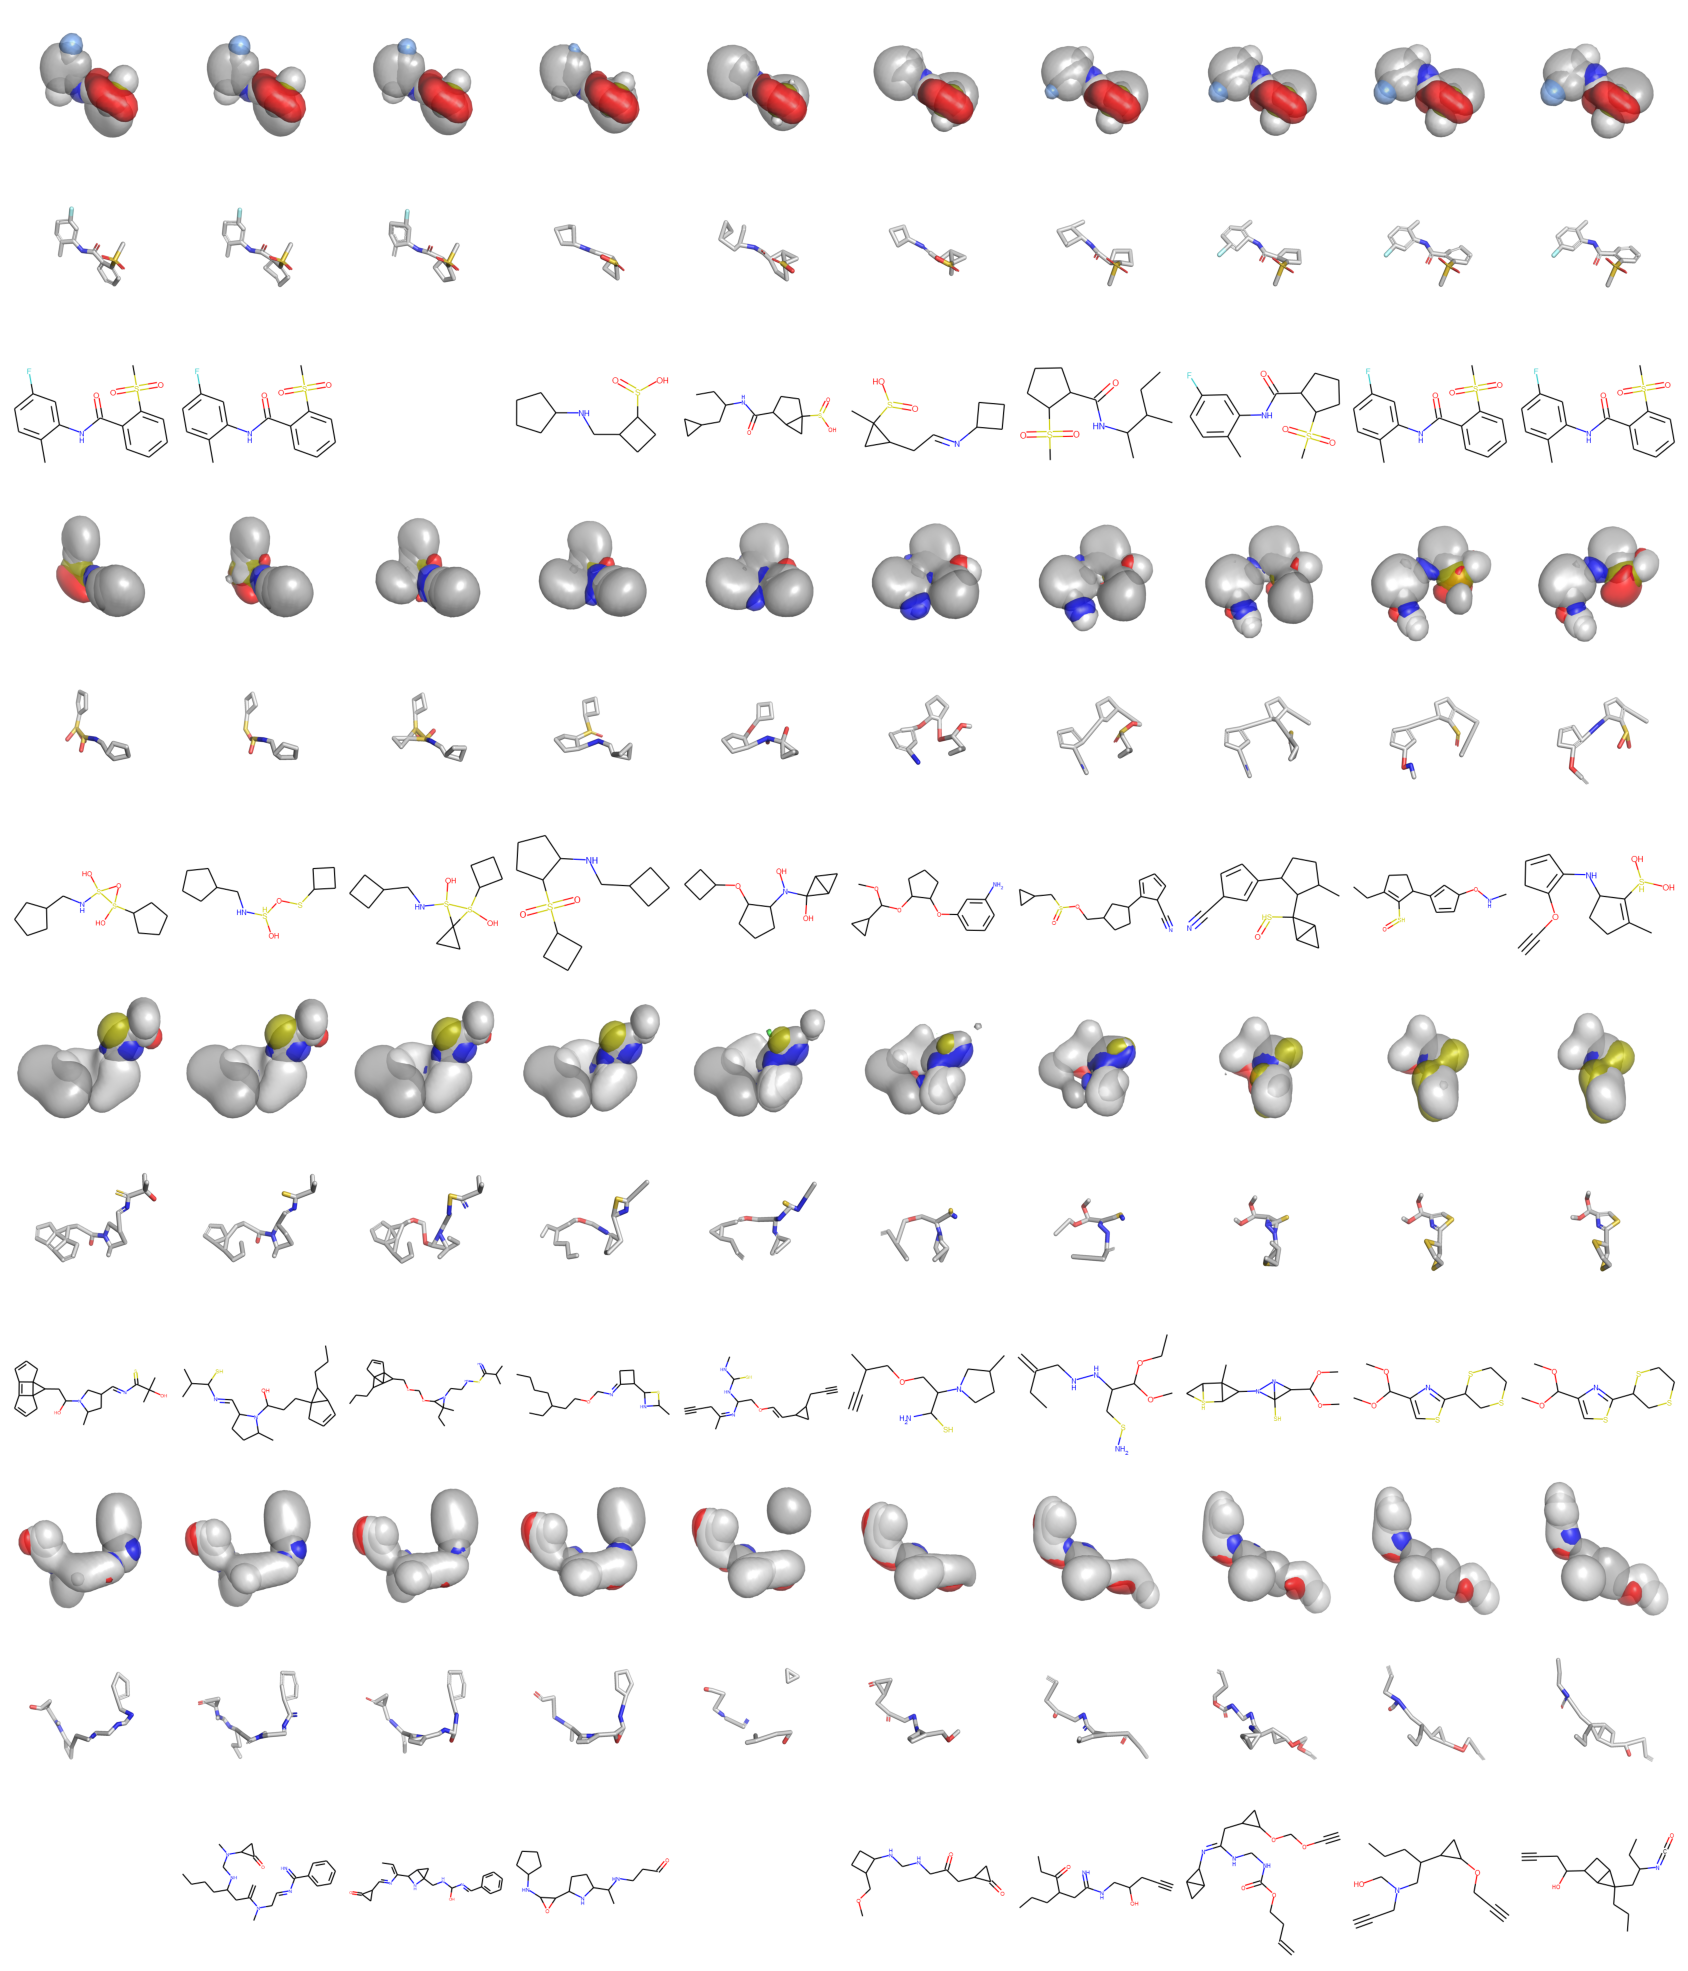

In [599]:
import matplotlib.image as mpimg

def smi_to_image(smi):
    mol = Chem.MolFromSmiles(smi)
    return Chem.Draw.MolToImage(mol)

y = ['lig_name', 'sample_idx', 'lig_gen_norm', 'lig_latent_norm', 'lig_gen_fit_add_valid', 'lig_gen_fit_add_SMILES']

lat_df['grid_image_file']   = lat_df[['latent_name', 'lig_idx', 'sample_idx']].apply(
    lambda x: latent_dir + '\\images\\' + x.iloc[0] + '\\grids\\grid{}_{:04d}.png'.format(x.iloc[1], x.iloc[2] + 1), axis=1)

lat_df['struct_image_file'] = lat_df[['latent_name', 'lig_idx', 'sample_idx']].apply(
    lambda x: latent_dir + '\\images\\' + x.iloc[0] + '\\structs\\struct{}_{:04d}.png'.format(x.iloc[1], x.iloc[2] + 1), axis=1)

_lat_df = lat_df.set_index(['latent_idx', 'interp_idx'])



n_rows = 3*len(latent_names)
n_cols = len(interp_idxs)
width = height = 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(width*n_cols, height*n_rows))

for latent_idx in range(len(latent_names)):
    for ax_idx, interp_idx in enumerate(interp_idxs):
        row = _lat_df.loc[latent_idx, interp_idx]

        ax = axes[3*latent_idx + 0, ax_idx]
        grid_im = mpimg.imread(row['grid_image_file'])
        ax.imshow(grid_im, aspect='auto')

        ax = axes[3*latent_idx + 1, ax_idx]
        struct_im = mpimg.imread(row['struct_image_file'])
        ax.imshow(struct_im, aspect='auto')

        ax = axes[3*latent_idx + 2, ax_idx]
        smi = row['lig_gen_fit_add_SMILES']
        try:
            mol_im = smi_to_image(smi)
            ax.imshow(mol_im, aspect='auto')
        except ValueError:
            pass

        for j in range(3):
            ax = axes[3*latent_idx + j, ax_idx]
            ax.set_xticklabels([])
            ax.set_yticklabels([])
    
sns.despine(fig, top=True, bottom=True, left=True, right=True)
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig('latent_interp1.png', bbox_inches='tight')
os.getcwd()

In [516]:
mol_df = lat_df = fit_df[(fit_df['dataset'] == 'pubchem') &
                (fit_df['iteration'] == 100000)]

ae_mol_df =
vae_mol_df =
pri_mol_df =

In [ ]:
n_rows = 3
n_cols = len(interp_idxs)
width = height = 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(width*n_cols, height*n_rows))

for ax_i, interp_i in enumerate(interp_idxs):
    row = lat_df.loc[interp_i]
    
    ax = axes[0,ax_i]
    grid_im = mpimg.imread(row['grid_image_file'])
    ax.imshow(grid_im, aspect='auto')
    
    ax = axes[1,ax_i]
    struct_im = mpimg.imread(row['struct_image_file'])
    ax.imshow(struct_im, aspect='auto')
    
    ax = axes[2,ax_i]
    smi = row['lig_gen_fit_add_SMILES']
    try:
        mol_im = smi_to_image(smi)
        ax.imshow(mol_im, aspect='auto')
    except ValueError:
        pass
    
    for j in range(3):
        ax = axes[j,ax_i]
        ax.set_xticklabels([])
        ax.set_yticklabels([])
    
sns.despine(fig, top=True, bottom=True, left=True, right=True)
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig('latent_interp1.png', bbox_inches='tight')
os.getcwd()